# Exercise 3

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt
import math
%matplotlib inline
np.set_printoptions(suppress=True)

## Curve Fitting by Linear Smoothing
### Part (B)

Set the non-linear function as $$f(x) = 2x^2+3x$$ and set the distribution of error as $$\epsilon \sim \mathcal{N}(0,1.5^2)$$

Randomly select our X's from Uniform$(-3,3)$ distribution.

In [2]:
def sim_noisy_data_nonlinear_function(n, X_range, err_std):
    """Simulate non-linear data.
    
    Args:
        n: number of data points.
        X_range: range of independent variable.
        err_std: the standard deviation of error term -- we let the error term to have N(0, std^2) distribution.
        
    Returns:
        return simulated dataset in an array of independent variable and an array of dependent variable.
    """
    X = np.linspace(-X_range/2., X_range/2., n)
    error = sps.norm.rvs(loc=0, scale=err_std, size=n)
    return X, 2*np.power(X, 2)+3*X+error

def kernel_function(distance, h, kernel="Gaussian"):
    """Compute unnormalized kernel weights with specified kernel function given distance and bandwidth.
    
    Args:
        distance: the difference between target data and training data, could be a scalar or vector.
        h: the value of bandwidth.
        kernel: a string of the name of kernel.
        
    Returns:
        the value of unnormalized kernel weights with the same dimension as distance.
    """
    if  kernel=="Gaussian":
        return sps.norm.pdf(distance/h)
    else:
        raise ValueError("Do not have this kernel option.")

def weighting_function(train_X, test_x_i, h, kernel="Gaussian"):
    """Compute the normalized weights for a new data point with training data and specified kernel.
    
    Args:
        train_X: an array of training data.
        test_x_i: the value of a new data point.
        h: the value of bandwidth.
        kernel: a string of the name of kernel.
    
    Returns:
        an array of normalized weights at each training data point.
    """
    if kernel=="Gaussian":
        unnormed_weights = (1./h)*sps.norm.pdf((train_X-test_x_i)/h)
        return unnormed_weights/np.sum(unnormed_weights)
    else:
        return None
    
def kernel_smoother(new_data, X_centered, y_centered, h, kernel="Gaussian"):
    """Fit a kernel smoother for an arbitrary new data.
    
    Args:
        new_data: new data that we are going to estimate using kernel smoother.
        X_centered: centered training explanatory variable.
        y_centered: centered training response variable.
        h: the value of bandwidth.
        kernel: a string of the name of kernel.
        
    Returns:
        the kernel regression estimator of new data.
    """
    f_estimate = np.array([*map(lambda X_star: \
        weighting_function(X_centered, X_star, h, kernel)@y_centered, new_data)])
    return f_estimate

In [3]:
X, y = sim_noisy_data_nonlinear_function(n=100, X_range=6, err_std=1.5)
# center the data
X_centered = X-np.mean(X)
y_centered = y-np.mean(y)

Text(0.5, 1.0, 'Simulated Data (Centered)')

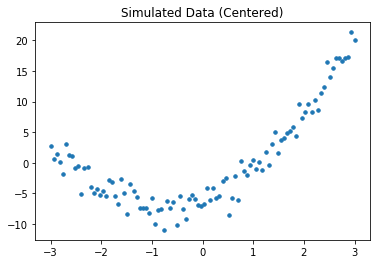

In [4]:
plt.scatter(X_centered, y_centered, s=12)
plt.title("Simulated Data (Centered)")

With Numpy, we don't have to implement the kernel function and weighting function differently: the same command can be operated at matrix level. For Gaussian kernel, since we've already have function in Scipy that implements that, we don't need to write extra functions.

To show the effect of kernel smoothing, we let the new data to be a list of numbers covering the range of $X$, with the same amount of small increments between two consecutive numbers, i.e. $-3,-2.99,-2.98, \dots$ We only impelement a function that take in the value of $h$, the value of bandwidth.

One more thing worth pointing out is that the weights $w(x_i, x^{\star})=\frac{1}{h}K(\frac{x_i - x^{\star}}{h})$ is unnormalized; we manually calculate the normalized weights by $\frac{w(x_i)}{\sum w(x_i)}$, instead of using normalize() function from sklearn package to normalize the weights -- which appears to be quite buggy and use-unfriendly.

Note in the following first plot: $0.001$, $0.005$, $0.01$ have almost the same plots, thus looking overlapped -- instead of $0.001$ and $0.005$ not showing.

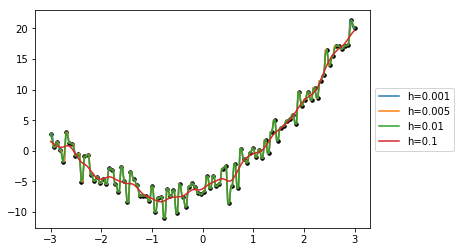

In [5]:
new_X = np.linspace(np.min(X_centered), np.max(X_centered), 200)
h_candidates = [0.001, 0.005, 0.01,.1]
smoothers_diff_h = [*map(lambda h_candidate: (h_candidate, kernel_smoother(\
                    new_data=new_X, X_centered=X_centered, y_centered=y_centered, h=h_candidate)), h_candidates)]
plt.scatter(X_centered, y_centered, color='black', s=12)
for smoother in smoothers_diff_h:
    plt.plot(new_X, smoother[1], label="h="+str(smoother[0]), alpha=.99)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

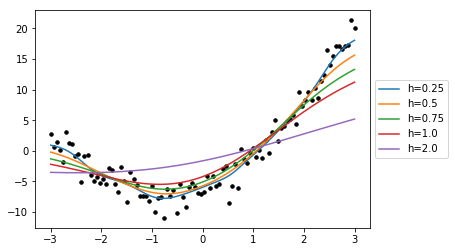

In [6]:
new_X = np.linspace(np.min(X_centered), np.max(X_centered), 200)
h_candidates = [.25, .5, .75, 1., 2.]
smoothers_diff_h = [*map(lambda h_candidate: (h_candidate, kernel_smoother(\
                    new_data=new_X, X_centered=X_centered, y_centered=y_centered, h=h_candidate)), h_candidates)]
plt.scatter(X_centered, y_centered, color='black', s=12)
for smoother in smoothers_diff_h:
    plt.plot(new_X, smoother[1], label="h="+str(smoother[0]), alpha=.99)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The fitted line gets smoother and smoother as bandwidth $h$ increases, but becomes less and less fit to the data; when $h=0.01$, the line overfits to the data very well, but when $h$ gets even smaller the line starts to fluctuate to much.

## Cross Validation
### Part (A)

We are almost done with this part -- the function asked for in this question is almost kernel_smoother() from above, except the error calculation, since we didn't have a y_test; however, this time I write a weighting function to make it posssible for us to adjust the kernel without touching the training-and-prediction function here.

In [7]:
def predict_and_compute_error(h, train_X, train_y, test_X, test_y, kernel="Gaussian"):
    """Compute the normalized weights for a new data point with training data and specified kernel.
    
    Args:
        h: the value of bandwidth.
        train_X: an array of training data.
        train_y: an array of training labels.
        test_X: an array of test data.
        test_y: an array of test labels.
        kernel: a string of the name of kernel.
    
    Returns:
        an array of test data predictions, a float of MSE.
    """
    f_estimate = np.array([*map(lambda x_star: weighting_function(train_X, x_star, h, kernel)@train_y, test_X)])
    return f_estimate, np.mean(np.power(test_y-f_estimate,2))

### Part (B)

We write a function to incorporate the two features of the simulated dataset: if the function is wiggly or smooth, and the noise level of the observations by the variance. We choose the trigonometric function sin(), and set different periods so wiggly function would have small period thus have multiple cycles in this interval, while smooth function have only just a part of a cycle so it appears smooth in the unit interval.

In [8]:
def simulate_y(X, function, err_var, seed):
    """Simulate y with different needs.
    
    Args:
        X: an array of data.
        function: has option "smooth" and "wiggly"
        err_var: the variance of error terms.
        seed: the value of random seed, to get deterministic result for error terms.
        
    Returns:
        Simulated array of y.
    """
    np.random.seed(seed=seed)
    if function=="smooth":
        y=np.sin(2*X)
    elif function=="wiggly":
        y=np.sin(20*X)
    else:
        raise ValueError("Do not have this option.")
    error = sps.norm.rvs(loc=0, scale=np.sqrt(err_var), size=y.shape[0])
    return y+error

We set training data to be from the unit interval: $[0,1]$, with equal distance.

In [9]:
all_X = np.linspace(0., 1., 500) # as the question asked we have 500 points

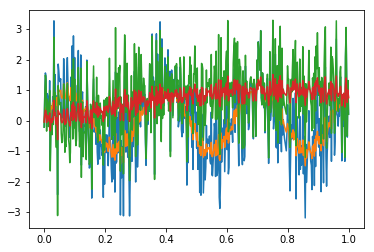

In [10]:
seed = 2019
# wiggly and noisy
wn_y = simulate_y(all_X, "wiggly", 1., seed)
plt.plot(all_X, wn_y)
# wiggly and stable
ws_y = simulate_y(all_X, "wiggly", .05, seed)
plt.plot(all_X, ws_y)
# smooth and noisy
sn_y = simulate_y(all_X, "smooth", 1., seed)
plt.plot(all_X, sn_y)
# smooth and stable
ss_y = simulate_y(all_X, "smooth", .05, seed)
plt.plot(all_X, ss_y)

#### Split the Data into Training and Test Set

Instead of manipulate on the data itself (i.e. shuffle rows directly on data), we shuffle the indices and split on it instead. This will have an impact when dataset is big enough to the point that a copy of it doesn't fit in memory.

In [11]:
def split_train_test_data(X, y, test_ratio, seed):
    """Split data into training and test set with specified portion of data for each.
    
    Args:
        X: an array of data.
        y: corresponding label of X.
        test_ratio: portion of test data.
        seed: the value of random seed, to get deterministic result for index shuffling.
        
    Returns:
        four arrays: training X, training y, test X, test y
    """
    n=X.shape[0]
    idx_array=np.arange(n)
    np.random.seed(seed=seed)
    np.random.shuffle(idx_array)
    n_test=int(n*test_ratio)
    return X[idx_array[n_test:]], y[idx_array[n_test:]], X[idx_array[:n_test]], y[idx_array[:n_test]]

In [12]:
# split data for all four scnarios; choose different seeds to shuffle data differently
data_dict = {}
# wiggly and noisy
data_dict['wn'] = split_train_test_data(all_X, wn_y, .2, 1)
# smooth and noisy
data_dict['sn'] = split_train_test_data(all_X, sn_y, .2, 2)
# wiggly and stable
data_dict['ws'] = split_train_test_data(all_X, ws_y, .2, 3)
# smooth and stable
data_dict['ss'] = split_train_test_data(all_X, ss_y, .2, 4)

In [13]:
# set a list of different values for h
h_candidates = [.0005,.001,.005,.01,.05,.1,.25,.5,1.,2.]

#### Compute Error for Different Values of $h$ under Each Scenario

We write the following function to avoid writing repeated code for making the plot:

In [14]:
def make_plots_and_return_predictions_and_MSEs(data_dict, h_candidates, current_scenario):
    """Create 3 plots: fit of Kernel Smoother under different values of h for test data, MSE of different
    values of h in one plot, and fit of best h in terms of giving the minimal MSE. Also return the fitted
    value array and MSE under different h.
    
    Args:
        data_dict: a dictionary of training and test data and labels mapped to different scenarios of function.
        h_candidates: a list of different values of h.
        current_scenario: the scenario of function we are interested in.
        
    Returns:
        a list of tuples, each of which has its first element as the value of h, the second element as the 
        fitted value of the kernel smoother on test data, and the third element is the value of MSE.
    """
    results = [*map(lambda h: (h,)+predict_and_compute_error(h, *data_dict[current_scenario]), h_candidates)]
    fig = plt.figure(figsize=(12,24))
    fig.subplots_adjust(hspace=0.3)
    ax = fig.add_subplot(3, 1, 1)
    ax.scatter(data_dict[current_scenario][2], data_dict[current_scenario][3], color='black', s=20)
    for smoother in results:
        ax.scatter(data_dict[current_scenario][2], smoother[1], label="h="+str(smoother[0]), alpha=.9, s=10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('test X')
    ax.set_ylabel('test y')
    ax.set_title(r'Fit of Different $h$ for %s' % current_scenario)

    ax = fig.add_subplot(3, 1, 2)
    ax.plot([element[0] for element in results],[element[2] for element in results])
    ax.set_xlabel(r'$h$')
    ax.set_ylabel('MSE')
    ax.set_title(r'MSE of Different Choices of $h$ for %s' % current_scenario)

    ax = fig.add_subplot(3, 1, 3)
    best=np.argmin([element[2] for element in results])
    ax.scatter(data_dict[current_scenario][2], data_dict[current_scenario][3], color='black', s=20)
    ax.scatter(data_dict[current_scenario][2], results[best][1], label="h="+str(results[best][0]), alpha=.9, s=10)
    ax.legend(loc='best')
    ax.set_xlabel('test X')
    ax.set_ylabel('test y')
    ax.set_title(r'Fit of Best $h$ for %s' % current_scenario)
    
    return results

##### Wiggly and Noisy:

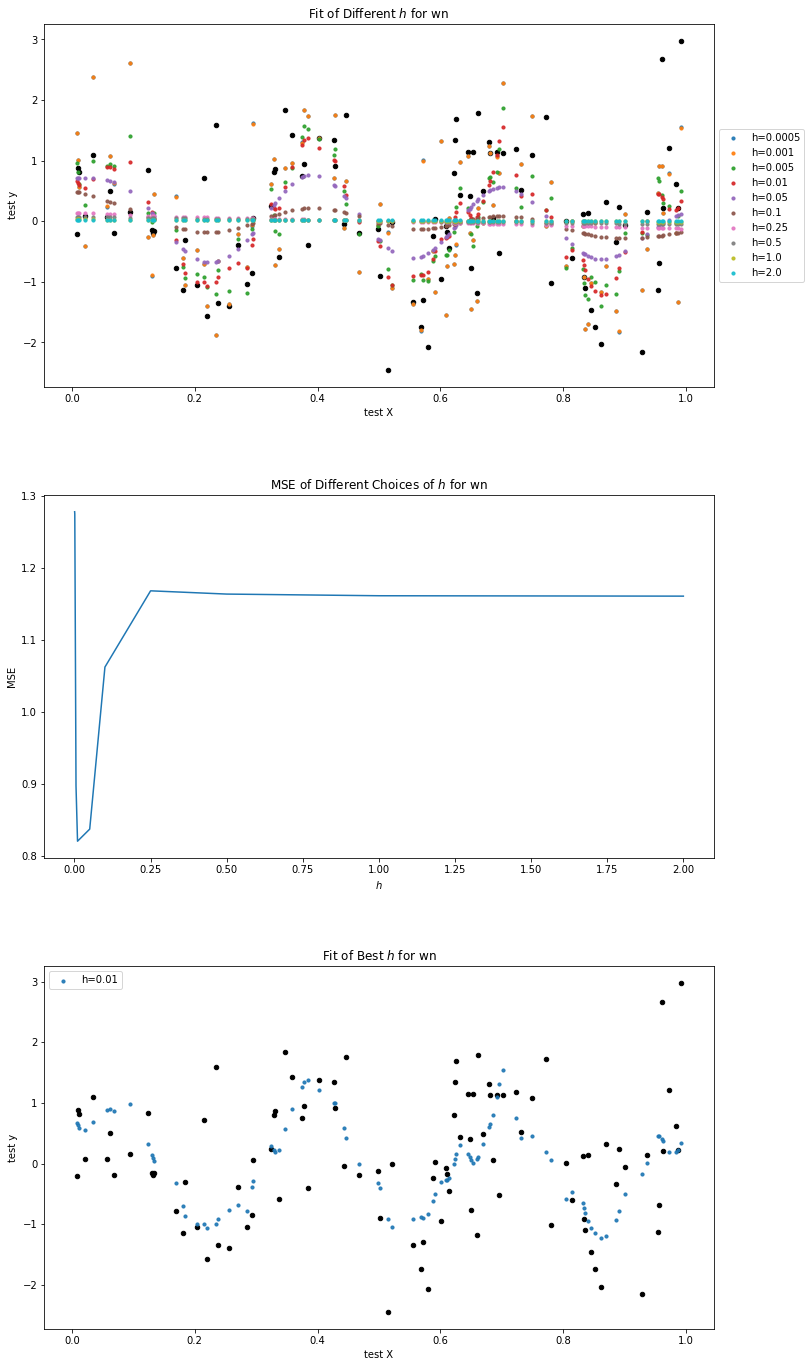

In [15]:
wn_results = make_plots_and_return_predictions_and_MSEs(data_dict, h_candidates, 'wn')

##### Wiggly and Stable

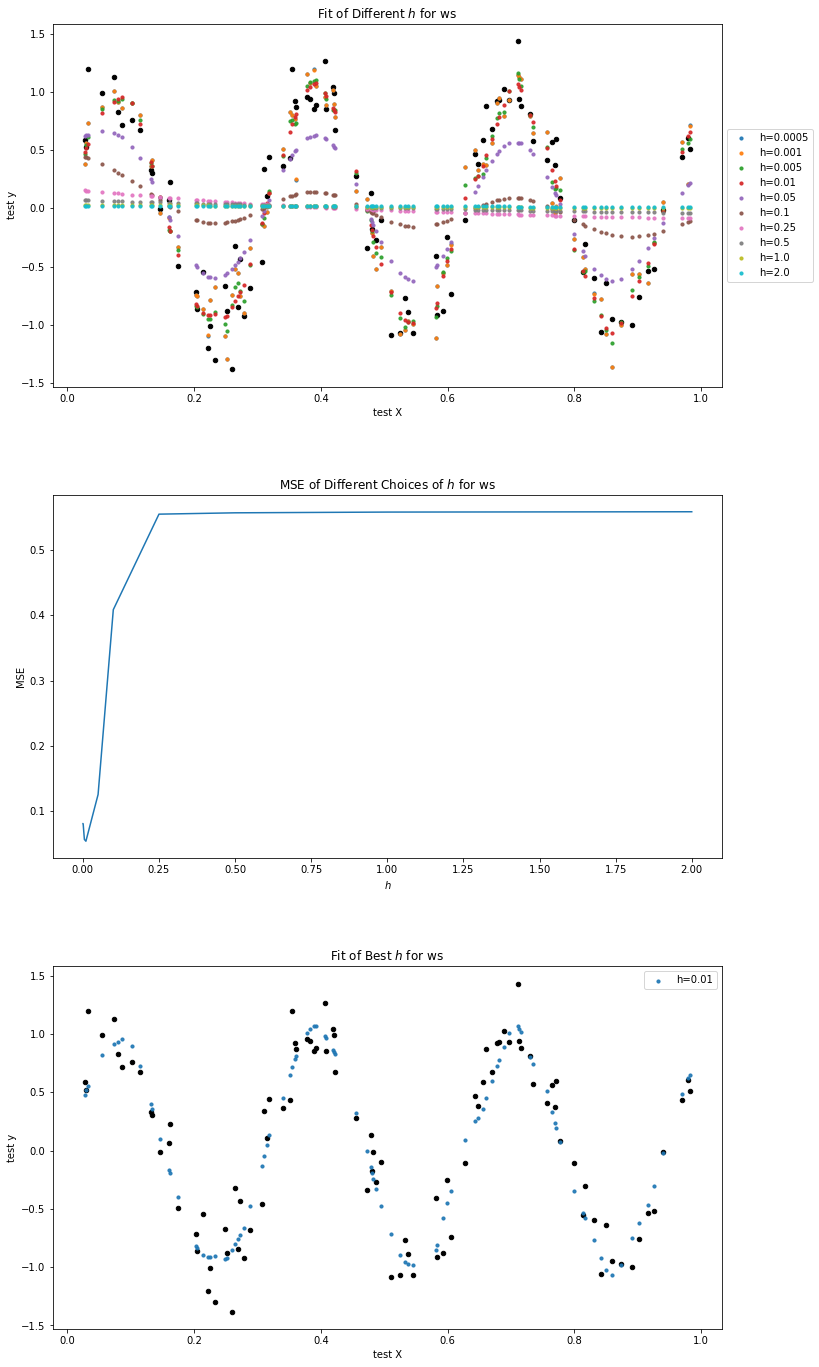

In [16]:
ws_results = make_plots_and_return_predictions_and_MSEs(data_dict, h_candidates, 'ws')

##### Smooth and Noisy

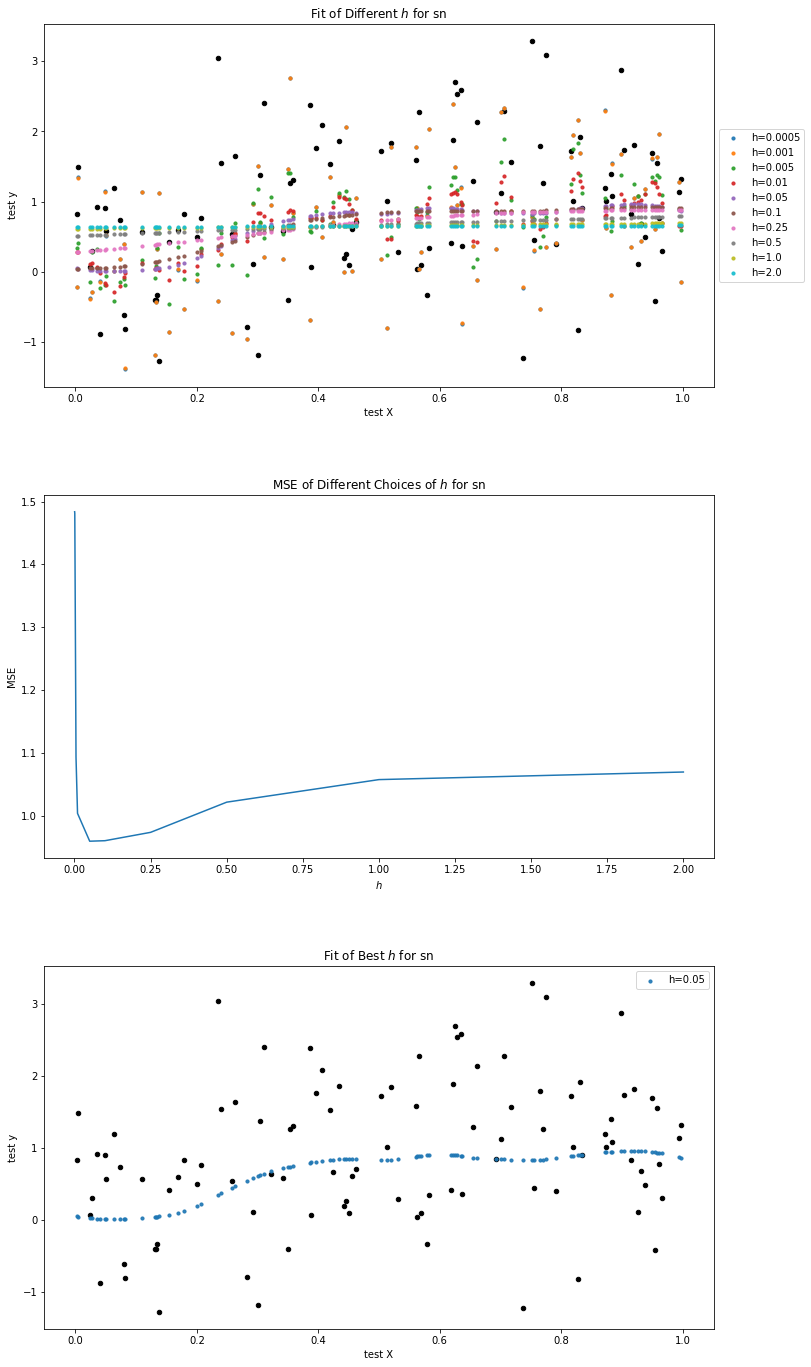

In [17]:
sn_results = make_plots_and_return_predictions_and_MSEs(data_dict, h_candidates, 'sn')

##### Smooth and Stable

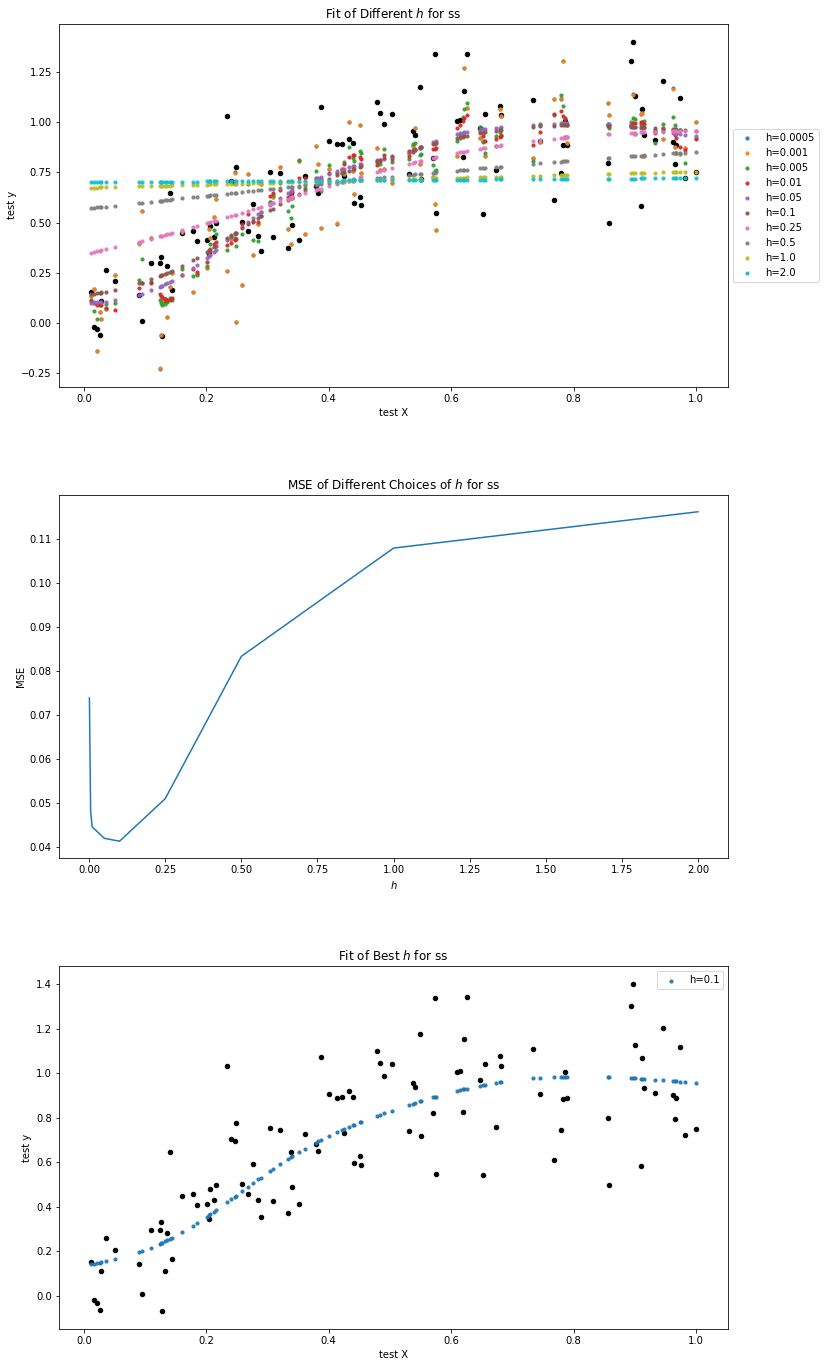

In [18]:
ss_results = make_plots_and_return_predictions_and_MSEs(data_dict, h_candidates, 'ss')

### Part (C)
#### Leave-One-Out Cross Validation (LOOCV)

The major change is from the way to compute error: instead of split the data into training and test set by proportion and compute MSE for test data, we fit a model for each data and compute its error. We write new function to incorporate such need:

In [19]:
def compute_LOOCV_error_for_ith_data(X, y, idx, h):
    idx_array=np.arange(X.shape[0])
    return predict_and_compute_error(h, X[idx_array!=idx], y[idx_array!=idx], \
                                      X[idx_array==idx], y[idx_array==idx])[1]
def compute_LOOCV_error(X, y, h):
    error_for_each_idx = [*map(lambda idx: compute_LOOCV_error_for_ith_data(X, y, idx, h), np.arange(X.shape[0]))]
    return np.sum(error_for_each_idx)

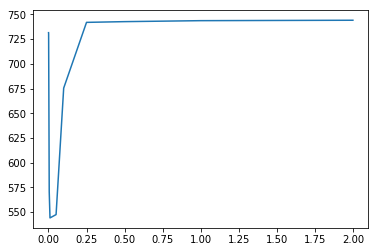

In [20]:
wn_loocv = [*map(lambda h: (h, compute_LOOCV_error(all_X, wn_y, h)), h_candidates)]
plt.plot([element[0] for element in wn_loocv], [element[1] for element in wn_loocv])

In [21]:
wn_loocv

[(0.0005, 731.571985341579),
 (0.001, 730.4813381492569),
 (0.005, 570.5130945600688),
 (0.01, 544.051915710923),
 (0.05, 547.4221064831092),
 (0.1, 675.4540254869961),
 (0.25, 741.9871383311825),
 (0.5, 742.7282866264301),
 (1.0, 743.7131114222537),
 (2.0, 744.139227178322)]

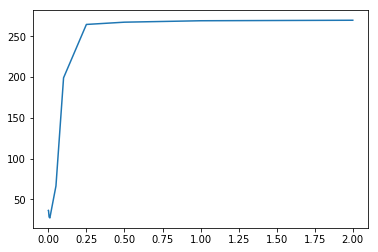

In [22]:
ws_loocv = [*map(lambda h: (h, compute_LOOCV_error(all_X, ws_y, h)), h_candidates)]
plt.plot([element[0] for element in ws_loocv], [element[1] for element in ws_loocv])

In [23]:
ws_loocv

[(0.0005, 36.58857446921682),
 (0.001, 36.53413427938385),
 (0.005, 28.55975973089477),
 (0.01, 27.378398545561552),
 (0.05, 66.51643377037146),
 (0.1, 199.03142909184967),
 (0.25, 264.4219114302675),
 (0.5, 267.1927800638332),
 (1.0, 268.9424213610438),
 (2.0, 269.5664032978517)]

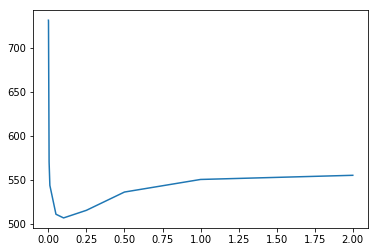

In [24]:
sn_loocv = [*map(lambda h: (h, compute_LOOCV_error(all_X, sn_y, h)), h_candidates)]
plt.plot([element[0] for element in sn_loocv], [element[1] for element in sn_loocv])

In [25]:
sn_loocv

[(0.0005, 731.5357549810026),
 (0.001, 730.4446406568425),
 (0.005, 570.4489908161363),
 (0.01, 544.0018373731939),
 (0.05, 511.2489526847486),
 (0.1, 507.06705772869),
 (0.25, 515.6902630658757),
 (0.5, 536.4477493910073),
 (1.0, 550.7400872696336),
 (2.0, 555.458295332984)]

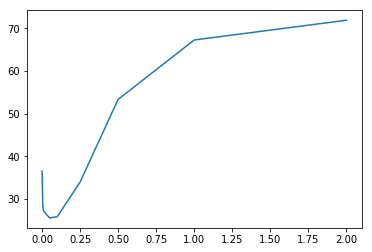

In [26]:
ss_loocv = [*map(lambda h: (h, compute_LOOCV_error(all_X, ss_y, h)), h_candidates)]
plt.plot([element[0] for element in ss_loocv], [element[1] for element in ss_loocv])

In [27]:
ss_loocv

[(0.0005, 36.57889217209289),
 (0.001, 36.524338567331924),
 (0.005, 28.525503117201715),
 (0.01, 27.197907284543803),
 (0.05, 25.57941851021338),
 (0.1, 25.860672746463297),
 (0.25, 33.95020300796326),
 (0.5, 53.363548886287276),
 (1.0, 67.30436965548083),
 (2.0, 71.93457725582357)]

Note that out-of-sample and LOOCV methods give us similar conclusions: only for wiggly and noisy function that large value of $h$, i.e. the one that gives a smooth and linear-esque shape tend to be the best; for all other three scenarios would the smallest $h$ work best. The shapes of the error plots for different values of $h$ look similar as well.

## Local Polynomial Regression
### Part (E)

Fit $y$ versus $x$ using local linear regression and some choice of kernel. Choose a bandwidth by leave-one-out cross-validation.

In [2]:
utilities_df=pd.read_csv('utilities.csv')
X = np.array(utilities_df['temp'])*1. # average temperature
y = np.array(utilities_df['gasbill']/utilities_df['billingdays']) # average daily gas bill

In [29]:
def compute_unnormalized_w_i(h, train_X, train_y, x_i, y_i, kernel="Gaussian"):
    """Compute unnormalized kernel weights for a specific data point.
    
    Args:
        h: the value of bandwidth.
        train_X: a numpy 2d array of training data -- independent variable.
        train_y: a numpy 2d array of training data -- dependent variable.
        x_i: "test data" -- independent variable.
        y_i: "test data" -- dependent variable.
        kernel: the name of kernel function.
    
    Returns:
        an array of unnormalized kernel weights.
    """
    kernel_x_i_no_i = kernel_function(train_X-x_i, h, kernel)
    unnormed_w_x_i_no_i = kernel_x_i_no_i * (kernel_x_i_no_i@np.power(train_X-x_i,2) - (train_X-x_i)*(kernel_x_i_no_i@np.power(train_X-x_i,1)))
    return unnormed_w_x_i_no_i

def compute_LOOCV_err_local_linreg(X, y, h, kernel="Gaussian"):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of independent variable.
        y: a 2d numpy array of dependent variable.
        h: the value of bandwidth.
        kernel: the name of kernel function.
    
    Returns:
        a scalar of LOOCV error, and an array of kernel smoother predictions of y.
    """
    N=X.shape[0]
    idx_array=np.arange(N)
    W_unnormed_row = np.array([*map(lambda idx: compute_unnormalized_w_i(h, \
                    X[idx_array!=idx], y[idx_array!=idx], X[idx_array==idx], y[idx_array==idx], kernel="Gaussian"), np.arange(N))])
    W = np.array([*map(lambda i: W_unnormed_row[i]/np.sum(W_unnormed_row[i]), np.arange(N))])
    y_pred = np.array([*map(lambda idx: W[idx]@y[idx_array!=idx], np.arange(N))])
    return np.sum(np.power(y-y_pred, 2)), y_pred

def make_LOOCV_error_plot(loocv_errs):
    """Make a plot of LOOCV errors against their h values.
    
    Args:
        loocv_errs: a list of tuple whose first element is bandwidth value h and second element is its corresponding 
                    LOOCV error.
    
    Returns:
        No return variable; simply making the plot with this function.
    """
    plt.plot([element[0] for element in loocv_errs], [element[1] for element in loocv_errs])
    plt.title(r"LOOCV Error for Different $h$")
    plt.xlabel(r"h")
    plt.ylabel("LOOCV Error")
    
def fit_plot_best_h(h_candidates, loocv_errs):
    """Make a plot of LOOCV errors against their h values.
    
    Args:
        loocv_errs: a list of tuple whose first element is bandwidth value h and second element is its corresponding 
                    LOOCV error.
    
    Returns:
        No return variable; simply making the plot with this function.
    """
    best_h_idx = np.argmin([element[1] for element in loocv_errs])
    print("The h that gives smallest LOOCV error is %.2f" % (h_candidates[best_h_idx]))
    plt.scatter(X, y)
    plt.scatter(X, loocv_errs[best_h_idx][2])
    plt.title(r"Fitted Points from Best $h$")
    plt.xlabel(r"X")
    plt.ylabel(r"y")

In [30]:
h_candidates = np.arange(1,10, 0.1)
loocv_err_diff_h = [*map(lambda h: (h,) + compute_LOOCV_err_local_linreg(X, y, h), h_candidates)]

The h that gives smallest LOOCV error is 6.90


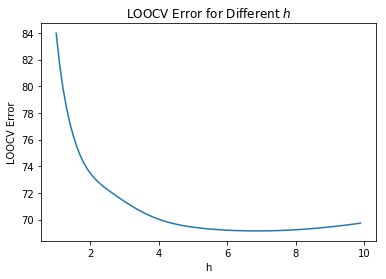

In [31]:
print("The h that gives smallest LOOCV error is %.2f" % (h_candidates[np.argmin([element[1] for element in loocv_err_diff_h])]))
make_LOOCV_error_plot(loocv_err_diff_h)

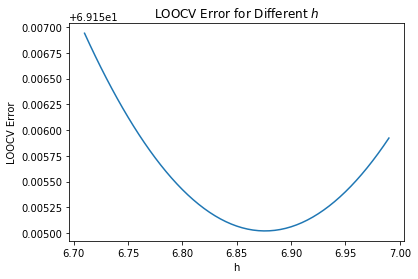

In [32]:
h_candidates = np.arange(6.71, 6.99, 0.005)
loocv_errs = [*map(lambda h: (h,) + compute_LOOCV_err_local_linreg(X, y, h), h_candidates)]
make_LOOCV_error_plot(loocv_errs)

The h that gives smallest LOOCV error is 6.87


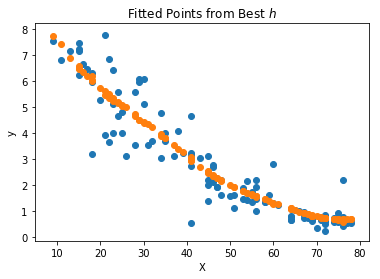

In [33]:
fit_plot_best_h(h_candidates, loocv_errs)

#### Summary for above function:

Before I was using normalize() from sklearn.preprocessing, and it appeared to be the function that mess up my calculation of normalized weights, and my fitted points when $X$ is small are way off. After normalizing the weights manually by using $\frac{w_i}{\sum w_i}$, I fixed the problem.

#### Unwillingly Trying For Loop

In [34]:
# remove the i-th point from the original data
h=6.8
kernel="Gaussian"
idx_array =np.arange(X.shape[0])

y_prediction = np.zeros(X.shape[0])
loocv_forloop_err = np.zeros(X.shape[0])
W = np.zeros((X.shape[0],X.shape[0]-1))
for i, x in enumerate(X):
    X_train, y_train = X[idx_array!=i], y[idx_array!=i]
    s1=np.sum(kernel_function(X_train-x, h, kernel)*(X_train-x))
    s2=np.sum(kernel_function(X_train-x, h, kernel)*np.power(X_train-x,2))
    unnormed_wi_x=kernel_function(X_train-x, h, kernel)*(s2-(X_train-x)*s1)
    W[i] = unnormed_wi_x/np.sum(unnormed_wi_x)
    y_prediction[i]=np.sum(W[i]*y_train)
    loocv_forloop_err[i] = np.sum(np.power(y[i]-y_prediction[i],2))
np.sum(loocv_forloop_err)

69.1554223594133

In [35]:
def loocv_forloop(X,y,h,kernel="Gaussian"):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of independent variable.
        y: a 2d numpy array of dependent variable.
        h: the value of bandwidth.
        kernel: the name of kernel function.
    
    Returns:
        a scalar of LOOCV error, and an array of kernel smoother predictions of y.
    """
    N=X.shape[0]
    idx_array =np.arange(N)
    y_prediction = np.zeros(N)
    loocv_forloop_err = np.zeros(N)
    W = np.zeros((N,N-1))
    for i, x in enumerate(X):
        X_train, y_train = X[idx_array!=i], y[idx_array!=i]
        s1=np.sum(kernel_function(X_train-x, h, kernel)*(X_train-x))
        s2=np.sum(kernel_function(X_train-x, h, kernel)*np.power(X_train-x,2))
        unnormed_wi_x=kernel_function(X_train-x, h, kernel)*(s2-(X_train-x)*s1)
        W[i] = unnormed_wi_x/np.sum(unnormed_wi_x)
        y_prediction[i]=np.sum(W[i]*y_train)
        loocv_forloop_err[i] = np.sum(np.power(y[i]-y_prediction[i],2))
    return np.sum(loocv_forloop_err), y_prediction

In [36]:
h_candidates= np.arange(1,10,0.1)
loocv_diff_h = [*map(lambda h: (h,)+loocv_forloop(X,y,h), h_candidates)]

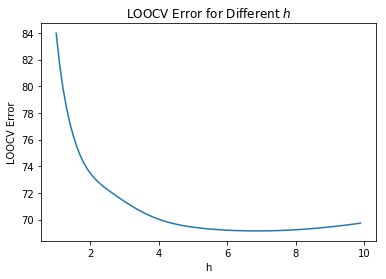

In [37]:
make_LOOCV_error_plot(loocv_diff_h)

The h that gives smallest LOOCV error is 6.90


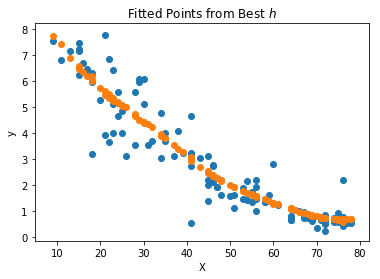

In [38]:
fit_plot_best_h(h_candidates, loocv_diff_h)

#### Try Smoothing Matrix

Note that we want to write the prediction in the form $$\mathbf{\hat{y}}=\mathbf{H y}$$ in which $$\hat{y}_i=\mathbf{H}_i^T\mathbf{y}$$ 


(1) If we do the usual leave-one-out scheme, we'd compute $W(x_i)$ for $i$-th data without itself. in this case for each prediction $\hat{y}_i^{(-i)}$ of $y_i$, we don't use the original data $y_i$, thus $\mathbf{H}_{ii}=0$ for $\forall i$.

(2) Part (C) from $\textbf{Cross Validation}$ section suggests that we can deduce that for linear smoother, we can compute LOOCV error without fitting the LOOCV models for each data, thus using $\hat{y}_i$.

#### Scheme (1) -- Fit LOOCV Model

69.15506081479958


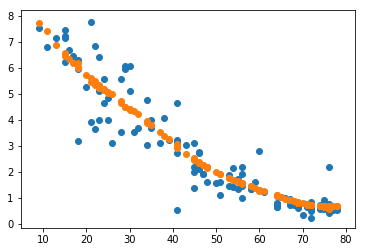

In [39]:
h=6.9
kernel="Gaussian"

N=X.shape[0]
idx_array =np.arange(N)
s1_X = np.sum(np.array([*map(lambda i: kernel_function(X[idx_array!=i]-X[idx_array==i], \
                            h, kernel)*(X[idx_array!=i]-X[idx_array==i]), np.arange(N))]), axis=1)
s2_X = np.sum(np.array([*map(lambda i: kernel_function(X[idx_array!=i]-X[idx_array==i], \
                            h, kernel)*np.power(X[idx_array!=i]-X[idx_array==i],2), np.arange(N))]), axis=1)
unnormed_wi_X = np.array([*map(lambda i: kernel_function(X[idx_array!=i]-X[idx_array==i], \
                            h, kernel)*(s2_X[i]-(X[idx_array!=i]-X[idx_array==i])*s1_X[i]), np.arange(N))])
wi_X = np.array([*map(lambda row: row/np.sum(row), unnormed_wi_X)])
#.reshape(-1,1) makes y a column vector
y_pred = np.array([*(map(lambda i: wi_X[i].dot(y[idx_array!=i].reshape(-1,1)), np.arange(N)))])
loocv_err_array = np.array([*map(lambda i: np.power((y[i]-y_pred[i])/(1.),2), np.arange(N))])
print(np.sum(loocv_err_array))
plt.scatter(X, y)
plt.scatter(X, y_pred)

In [40]:
def loocv_linear_smoother_matrix_calculation_no_trick(X, y, h, kernel="Gaussian"):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of independent variable.
        y: a 2d numpy array of dependent variable.
        h: the value of bandwidth.
        kernel: the name of kernel function.
    
    Returns:
        a scalar of LOOCV error, and an array of kernel smoother predictions of y.
    """
    # i-th element must be removed from the original dataset to fit the model to predict x_i
    N=X.shape[0]
    idx_array =np.arange(N)
    s1_X = np.sum(np.array([*map(lambda i: kernel_function(X[idx_array!=i]-X[idx_array==i], \
                                h, kernel)*(X[idx_array!=i]-X[idx_array==i]), np.arange(N))]), axis=1)
    s2_X = np.sum(np.array([*map(lambda i: kernel_function(X[idx_array!=i]-X[idx_array==i], \
                                h, kernel)*np.power(X[idx_array!=i]-X[idx_array==i],2), np.arange(N))]), axis=1)
    unnormed_wi_X = np.array([*map(lambda i: kernel_function(X[idx_array!=i]-X[idx_array==i], \
                                h, kernel)*(s2_X[i]-(X[idx_array!=i]-X[idx_array==i])*s1_X[i]), np.arange(N))])
    wi_X = np.array([*map(lambda row: row/np.sum(row), unnormed_wi_X)])
    #.reshape(-1,1) makes y a column vector
    y_pred = np.array([*(map(lambda i: wi_X[i].dot(y[idx_array!=i].reshape(-1,1)), np.arange(N)))])
    loocv_err_array = np.array([*map(lambda i: np.power((y[i]-y_pred[i])/(1),2), np.arange(N))])
    loocv_err = np.sum(loocv_err_array)
    return np.sum(loocv_err_array), y_pred

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


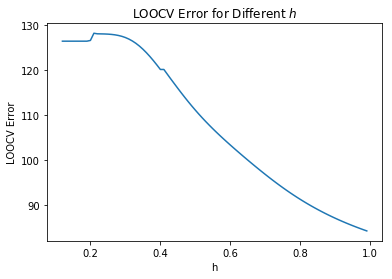

In [41]:
h_candidates = np.arange(0.01,1,0.01)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_no_trick(X, y, h), h_candidates)]
make_LOOCV_error_plot(loocv_errs)

In [42]:
math.isnan([element[1] for element in loocv_errs][0])

True

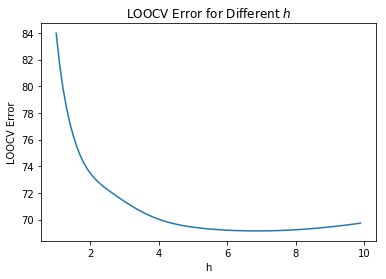

In [43]:
h_candidates = np.arange(1,10, 0.1)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_no_trick(X, y, h), h_candidates)]
make_LOOCV_error_plot(loocv_errs)

The h that gives smallest LOOCV error is 6.90


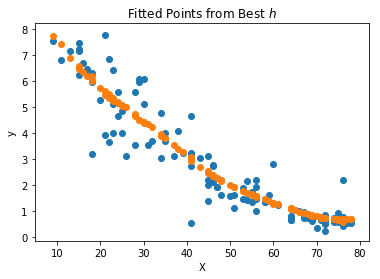

In [44]:
fit_plot_best_h(h_candidates, loocv_errs)

#### Scheme (2) -- Fit Model with Entire Data to Compute LOOCV

In [45]:
# no map function
h=6.9
kernel="Gaussian"

N=X.shape[0]
W = np.zeros((N,N))
for i in range(N):
    kernel_x_i = kernel_function(X-X[i], h, kernel)
    s1_x_i = kernel_x_i@(X-X[i])
    s2_x_i = kernel_x_i@np.power(X-X[i],2)
    W_i_unnormed = kernel_x_i*(s2_x_i - (X-X[i])*s1_x_i)
    W[i] = W_i_unnormed/np.sum(W_i_unnormed)
y_pred = W@y
np.sum(np.power((y-y_pred)/(1-np.diagonal(W)),2))

69.15506081479955

In [46]:
def loocv_linear_smoother_matrix_calculation_no_map_func(X, y, h, kernel="Gaussian"):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of independent variable.
        y: a 2d numpy array of dependent variable.
        h: the value of bandwidth.
        kernel: the name of kernel function.
    
    Returns:
        a scalar of LOOCV error, and an array of kernel smoother predictions of y.
    """
    N=X.shape[0]
    W = np.zeros((N,N))
    for i in range(N):
        kernel_x_i = kernel_function(X-X[i], h, kernel)
        s1_x_i = kernel_x_i@(X-X[i])
        s2_x_i = kernel_x_i@np.power(X-X[i],2)
        W_i_unnormed = kernel_x_i*(s2_x_i - (X-X[i])*s1_x_i)
        W[i] = W_i_unnormed/np.sum(W_i_unnormed)
    y_pred = W@y
    return np.sum(np.power((y-y_pred)/(1-np.diagonal(W)),2)), y_pred

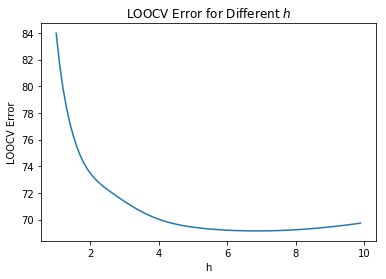

In [47]:
h_candidates = np.arange(1,10, 0.1)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_no_map_func(X, y, h), h_candidates)]
make_LOOCV_error_plot(loocv_errs)

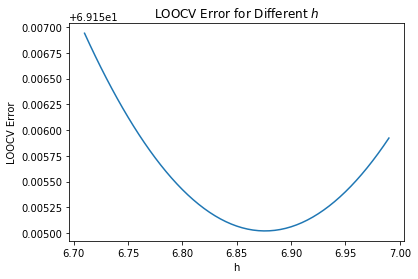

In [48]:
h_candidates = np.arange(6.71, 6.99, 0.005)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_no_map_func(X, y, h), h_candidates)]
make_LOOCV_error_plot(loocv_errs)

The h that gives smallest LOOCV error is 6.87


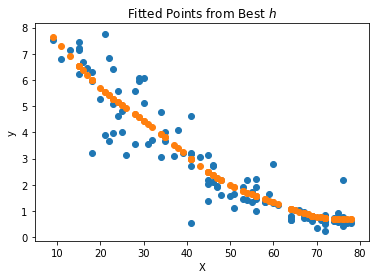

In [49]:
fit_plot_best_h(h_candidates, loocv_errs)

In [50]:
# with map function
kernel="Gaussian"
h = 6.9
N=X.shape[0]
W_unnormed_row = np.array([*map(lambda i: 
                   kernel_function(X-X[i], h, kernel) \
                    *((kernel_function(X-X[i], h, kernel)@np.power(X-X[i],2)) \
                    - (X-X[i])*(kernel_function(X-X[i], h, kernel)@np.power(X-X[i],1))) \
                   , np.arange(N))])
W = np.array([*map(lambda i: W_unnormed_row[i]/np.sum(W_unnormed_row[i]), np.arange(N))])
y_pred = W@y
np.sum(np.power((y-y_pred)/(1-np.diagonal(W)),2))

69.15506081479955

In [28]:
def loocv_linear_smoother_matrix_calculation_using_map_func(X, y, h, kernel="Gaussian"):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of independent variable.
        y: a 2d numpy array of dependent variable.
        h: the value of bandwidth.
        kernel: the name of kernel function.
    
    Returns:
        a scalar of LOOCV error, and an array of kernel smoother predictions of y.
    """
    N=X.shape[0]
    # first compute weights for each data point x_i -- one thing about map function in Python that's 
    # different than the one in Scala is that it doesn't support inline assignment, thus in the computation of 
    # each unnormalized W, in which we need to compute the weights multiple times, we cannot just assign it 
    # to some variable, and use that variable to continue the calculation. We thus write the following two map() functions,
    # the first one compute the weights, the second one use these weights to continue to compute W
    kernel_X = np.array([*map(lambda i: kernel_function(X-X[i], h, kernel), np.arange(N))])
    W_unnormed_row = np.array([*map(lambda i: 
                kernel_X[i]*((kernel_X[i]@np.power(X-X[i],2))- (X-X[i])*(kernel_X[i]@np.power(X-X[i],1))), np.arange(N))])
    W = np.array([*map(lambda i: W_unnormed_row[i]/np.sum(W_unnormed_row[i]), np.arange(N))])
    y_pred = W@y
    return np.sum(np.power((y-y_pred)/(1-np.diagonal(W)),2)), y_pred

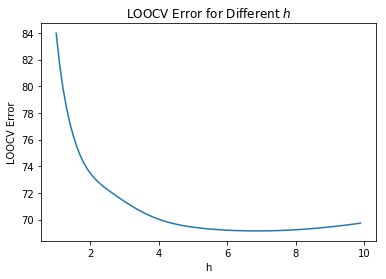

In [52]:
h_candidates = np.arange(1,10, 0.1)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_using_map_func(X, y, h), h_candidates)]
make_LOOCV_error_plot(loocv_errs)

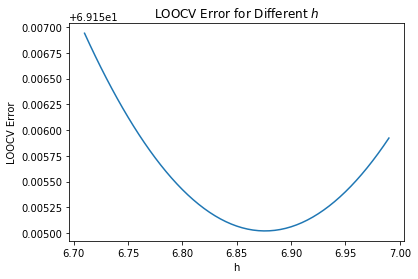

In [53]:
h_candidates = np.arange(6.71, 6.99, 0.005)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_using_map_func(X, y, h), h_candidates)]
make_LOOCV_error_plot(loocv_errs)

The h that gives smallest LOOCV error is 6.87


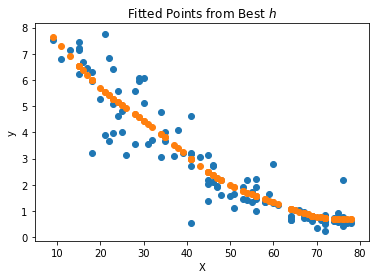

In [54]:
fit_plot_best_h(h_candidates, loocv_errs)

### Part (F)

Inspect the residuals from the model you just ﬁt. Check if the assumption of constant variance (homoscedasticity) look reasonable.

Text(0.5, 1.0, 'Residual of Best Fit Model when $h=6.875$')

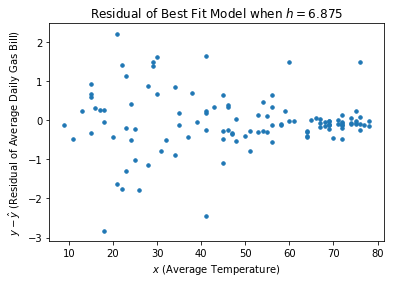

In [35]:
# get the best fit
h_candidates = np.arange(6.71, 6.99, 0.005)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_using_map_func(X, y, h), h_candidates)]
best_h_index = np.argmin([element[1] for element in loocv_errs])
best_fit_y_pred = loocv_errs[best_h_index][2]
plt.scatter(X, y-best_fit_y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.title(r'Residual of Best Fit Model when $h=%.3f$' % h_candidates[best_h_index])

We observe clear heteroscedasticity from above residual plot from the best fit model in terms of the $h$ that gives the smallest LOOCV error -- as $x$ increases, the residuals appear to be having less variance.

$\textbf{Why would heteroscedasticity be an issue?}$

Since as we'll see in Part $(G)$, we estimate the variance at each test data point using $$var(\hat{f}(x))\approx \big(\sum w_i^2(x)\big)\hat{\sigma}^2$$ in which $\hat{\sigma}^2$ is the estimator for $\sigma^2$, the assumed "global variance" for error term. If heteroscedasticity emerges, we cannot plug that estimator in because we don't have a united variance across the domain of data.

To fix the heteroscedasticity problem, we apply log-transformation on the response variable, i.e. take $\log(y)$ from the original value and fit a linear smoother for $\log(y)$ versus $X$. We can already observe homoscedasticity on original best fit for $h=6.985$: 

(although there are one or two points having much greater/smaller residual, they can be treated as outliers thus don't effect the overall homoscedasticity trend)

Text(0.5, 1.0, 'Residual of Best Fit Model on Original Scale when $h=6.875$')

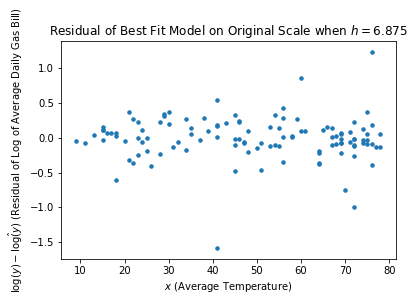

In [36]:
log_y = np.log(y)
original_y_scale_best_h = h_candidates[best_h_index]
loocv_err_and_pred = loocv_linear_smoother_matrix_calculation_using_map_func(X, log_y, original_y_scale_best_h)
plt.scatter(X, log_y-loocv_err_and_pred[1], s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$\log(y)-\hat{\log(y)}$ (Residual of Log of Average Daily Gas Bill)')
plt.title(r'Residual of Best Fit Model on Original Scale when $h=%.3f$' % original_y_scale_best_h)

Meanwhile, by changing the scale of $y$, we observe that the best $h$ in terms of giving the smallest LOOCV error would change as well. From the folllowing computation we have the best $h$ shall be $5.435$, whose residual plots demonstrate clear homoscedasticity with only a few outliers:

In [57]:
h_candidates = np.arange(1., 10., 0.05)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_using_map_func(X, log_y, h), h_candidates)]
print(r"Best $h$ has a value of %.2f" % h_candidates[np.argmin([element[1] for element in loocv_errs])])

Best $h$ has a value of 5.45


Text(0.5, 1.0, 'Residual of Best Fit Model on New Scale when $h=5.435$')

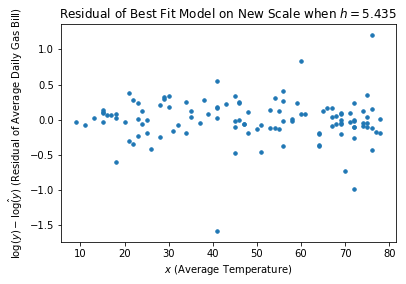

In [58]:
# get the best fit
h_candidates = np.arange(5.4, 5.5, 0.005)
loocv_errs = [*map(lambda h: (h,) + loocv_linear_smoother_matrix_calculation_using_map_func(X, log_y, h), h_candidates)]
best_h_index = np.argmin([element[1] for element in loocv_errs])
best_fit_log_y_pred = loocv_errs[best_h_index][2]
plt.scatter(X, log_y-best_fit_log_y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$\log(y)-\hat{\log(y)}$ (Residual of Average Daily Gas Bill)')
plt.title(r'Residual of Best Fit Model on New Scale when $h=%.3f$' % h_candidates[best_h_index])

### Part (G)

Construct an approximate point-wise $95\%$ conﬁdence interval for the local linear model (using your chosen bandwidth) for the value of the function at each of the observed points $x_i$ for the utilities data. Plot these conﬁdence bands, along with the estimated function, on top of a scatter plot of the data. It's ﬁne to use Gaussian critical values for the conﬁdence set.

We use the result we derived in Part (D) as the estimator for variance $\sigma^2$: $$\hat{\sigma}^2 = \frac{(y-Wy)^T(y-Wy)}{n-2\text{trace}(W)+\text{trace}(W^TW)}$$ 

Using this estimator, we continue to use our result in Part (C) to derive an estimator for the variance of $\hat{f}$:

$$var(\hat{f}(x))=\frac{\sum w_i^2(x)}{\big(\sum w_i(x)\big)^2}\sigma^2 \approx \frac{\sum w_i^2(x)}{\big(\sum w_i(x)\big)^2}\hat{\sigma}^2$$

And if weights are normalized, we'd have $\big(\sum w_i(x)\big)^2$ thus 

$$var(\hat{f}(x))\approx \big(\sum w_i^2(x)\big)\hat{\sigma}^2$$

In [39]:
def linear_smoother_on_test_data(X, y, test_X, h, kernel="Gaussian"):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of training independent variable.
        y: a 2d numpy array of training dependent variable.
        test_X: a 2d numpy array of test independent variable.
        h: the value of bandwidth.
        kernel: the name of kernel function.
    
    Returns:
        a 2d array of weight matrix and a 1d array of prediction.
    """
    N=test_X.shape[0]
    kernel_test_X = np.array([*map(lambda i: kernel_function(X-test_X[i], h, kernel), np.arange(N))])
    W_unnormed_row = np.array([*map(lambda i: 
                kernel_test_X[i]*((kernel_test_X[i]@np.power(X-test_X[i],2))- \
                (X-test_X[i])*(kernel_test_X[i]@np.power(X-test_X[i],1))), np.arange(N))])
    W = np.array([*map(lambda i: W_unnormed_row[i]/np.sum(W_unnormed_row[i]), np.arange(N))])
    y_pred = W@y
    return W, y_pred

In [60]:
chosen_h = 5.435
# compute weight matrix and prediction at each observed points
W, log_y_pred = linear_smoother_on_test_data(X, log_y, X, chosen_h)

It appears that if we only compute the predicted value and $95\%$ confidence interval at each observed points, the plots don't look good -- they showed up as not-so-smooth curve and does-not-make-any-sense confidence bands as follows:

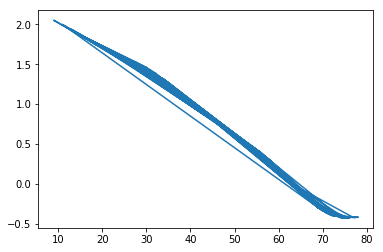

In [61]:
plt.plot(X, log_y_pred)

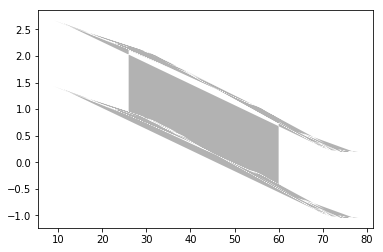

In [62]:
critical_value_97point5 = 1.96
residual = log_y-log_y_pred
sigma2_hat = (residual@residual)/(log_y.shape[0]-2*np.trace(W)+np.trace((W.T)@W))
upper_bound = log_y_pred + critical_value_97point5*np.sqrt(sigma2_hat)
lower_bound = log_y_pred - critical_value_97point5*np.sqrt(sigma2_hat)
plt.fill_between(x=X, y1=lower_bound, y2=upper_bound, facecolor='grey', alpha=0.6)

Therefore, I decide to construct a new set of points with equal-and-small distance to each other by using numpy.linspace() function, and compute the prediction, build the confidence interval and connect them to make the plot:

In [52]:
def make_confidence_interval(X, y, chosen_h, critical_value_97point5, ylabel, kernel="Gaussian", granularity=500, take_exponent=False):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of independent variable.
        y: a 2d numpy array of dependent variable.
        chosen_h: the selected value of bandwidth.
        critical_value_97point5: 97.5 percentile critical value.
        ylabel: a string of the title for y-axis.
        kernel: the name of kernel function.
        granularity: the granularity of the confidence band, indicated by the number of points in the range of X
                     that we are computing the confidence interval for.
        take_exponent: a boolean value indicates whether we want to take exp() on original data -- this would set to True if we transform
                       the response variable to the log scale, and want to see what the confidence interval look on the original scale --
                       the way to do it is through taking exp() on upper bound values, lower bound values, true response value and 
                       predicted value
    
    Returns:
        no return value; making the plot of 95% confidence interval with estimated function,
        along with scatter plot of observed and fitted data.
    """
    W, y_pred = linear_smoother_on_test_data(X, y, X, chosen_h)
    residual = y-y_pred
    sigma2_hat = (residual@residual)/(y.shape[0]-2*np.trace(W)+np.trace((W.T)@W))
    new_X = np.linspace(np.min(X), np.max(X), granularity)
    new_W, new_data_pred = linear_smoother_on_test_data(X, y, new_X, chosen_h, kernel)
    # compute the estimator for the variance at each point
    var_f_hat = np.sum(np.power(new_W,2),axis=1)*sigma2_hat
    upper_bound = np.exp(new_data_pred + critical_value_97point5*np.sqrt(var_f_hat)) if take_exponent \
                    else new_data_pred + critical_value_97point5*np.sqrt(var_f_hat)
    lower_bound = np.exp(new_data_pred - critical_value_97point5*np.sqrt(var_f_hat)) if take_exponent \
                    else new_data_pred - critical_value_97point5*np.sqrt(var_f_hat)
    plt.scatter(X, np.exp(y), label='observed', s=6, color='dodgerblue') if take_exponent \
                else plt.scatter(X, y, label='observed', s=6, color='dodgerblue')
    plt.scatter(X, np.exp(y_pred), label='prediction', s=8, color='black') if take_exponent \
                else plt.scatter(X, y_pred, label='prediction', s=8, color='black')
    plt.plot(new_X, np.exp(new_data_pred), label='estimated function', color='r') if take_exponent \
                else plt.plot(new_X, new_data_pred, label='estimated function', color='r')
    plt.fill_between(x=new_X, y1=lower_bound, y2=upper_bound, facecolor='grey', alpha=0.5, label=r'$95\% CI$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Average Temperature')
    plt.ylabel(ylabel)
    plt.title(r'$95\%$ Confidence Interval for Linear Smoother with' + ' $h=%.3f$' % chosen_h)

We work on $log(y)$ which has homoscedasticity:

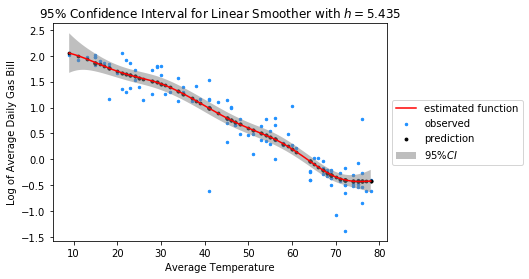

In [53]:
make_confidence_interval(X=X, y=log_y, chosen_h=5.435, critical_value_97point5=1.96, ylabel='Log of Average Daily Gas Bill')

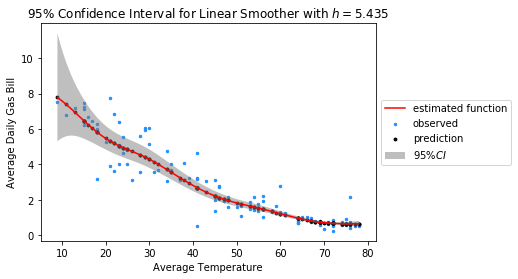

In [54]:
make_confidence_interval(X=X, y=log_y, chosen_h=5.435, critical_value_97point5=1.96, ylabel='Average Daily Gas Bill', take_exponent=True)

We observe that on the log scale of $y$, a rather narrow $95\%$ confidence interval that many points fall outside of the interval, but just a few that are really far away. The confidence intervals at both ends appear to be wider than the intervals in the middle of the range of $X$.

After we project the actual and predicted response values back to the original scale by taking $\exp()$, we observe that as $X$ (average temperature) increases, thte confidence band gets narrower and narrower. This observation is consistent with the observed data in the sense that as $X$ increases, data points are more clustered together, thus the model becomes more sure about its prediction.

Meanwhile, here is the plot of $95\%$ confidence interval on original scale of response variable when directly fit the model on the original scale: the confidence interval appears apparently wider on larger values of $X$, instead of having the shrinking trend as above when we fit a model on log scale and project the values back.

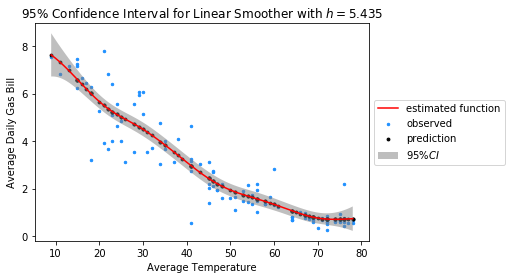

In [55]:
make_confidence_interval(X=X, y=y, chosen_h=5.435, critical_value_97point5=1.96, ylabel='Average Daily Gas Bill')

#### Variance Regression

Lastly, I want to write down here something I learnt in class: instead of simply taking the log of response variable and fit a model, we might work with something called variance regression: we try to fit a linear or more complicated model on log of squared residual. Then when new data comes in, we make a prediction on its log squared residual, and incorporate its inverse into forming the new weight term of our linear smoother: denote such prediction as $\hat{v}_i$, we could modify our previous $w_i(x)$ to be $w_i(x)\cdot\frac{1}{v_i}$ (or $w_i(x)\cdot\frac{1}{v_i^2}$ or even higher powers, depending on how much we want to mitigate the impact of data points with large residuals).

The idea is that if the fit on training data has larger residual, the prediction at this point should be treated as less trustworthy, thus the inverse of residual at this point would be small, thus diminish this data point's effect on prediction. 

We have the following plot of log of squared residual:

Text(0.5, 1.0, 'Log of Squared Residual Scatterplot')

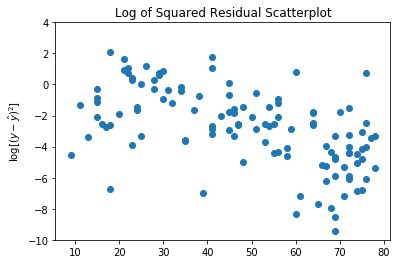

In [64]:
_, y_pred = linear_smoother_on_test_data(X=X, y=y, test_X=X, h=5.435)
plt.scatter(X, np.log(np.power(y-y_pred,2)))
plt.ylim(-10,4)
plt.ylabel(r"$\log[(y-\hat{y})^2]$")
plt.title("Log of Squared Residual Scatterplot")

We observe kind of a downward trend, or if we want to fit a quadratic model then it would be a concave curve, for the log of squared residual as $X$ increases. Let's give it a try:

Text(0.5, 1.0, 'Fitted Quadratic Curve for Log Squared Residual')

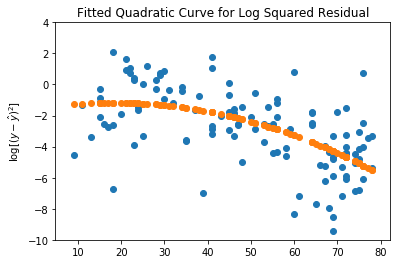

In [91]:
log_residual_sqd = np.log(np.power(y-y_pred,2)).reshape(-1,1)
X_quad = np.concatenate([np.ones((X.shape[0],1)), X.reshape(-1,1),(X*X).reshape(-1,1)],axis=1)
beta_hat = np.linalg.inv((X_quad.T)@X_quad)@(X_quad.T)@log_residual_sqd
log_residual_sqd_pred = X_quad@beta_hat
plt.scatter(X, log_residual_sqd)
plt.scatter(X, log_residual_sqd_pred)
plt.ylim(-10,4)
plt.ylabel(r"$\log[(y-\hat{y})^2]$")
plt.title("Fitted Quadratic Curve for Log Squared Residual")

In [98]:
log_residual_sqd_pred.flatten()[:20] # notice that all predictions are negative -- we don't

array([-1.24493182, -1.17711272, -1.21327265, -1.79484412, -2.03461527,
       -3.28298653, -3.93673123, -4.67870233, -4.67870233, -3.7090134 ,
       -2.71746823, -1.59428471, -1.24643449, -4.4215757 , -5.22236439,
       -5.08277277, -3.7090134 , -2.46779398, -2.24017632, -1.20111916])

The fit looks reasonable -- let's try to incorporate it into the make of new kernel weights:

In [103]:
def linear_smoother_with_variance_regression_on_test_data(X, y, test_X, h, variance_reg="quadratic", residual_power=1, kernel="Gaussian"):
    """Compute LOOCV error for a kernel smoother with a specified bandwidth.
    
    Args:
        X: a 2d numpy array of training independent variable.
        y: a 2d numpy array of training dependent variable.
        test_X: a 2d numpy array of test independent variable.
        h: the value of bandwidth.
        variance_reg: the name of variance regression function -- has options of "linear", "quadratic" and "itself".
        residual_power: a scalar indicates the extent to which we want to shrink the original weight by (log squared predicted) residual at that point.
        kernel: the name of kernel function.
    
    Returns:
        a 2d array of weight matrix and a 1d array of prediction.
    """
    # we first fit the prediction solely on training data, for the purpose of getting their residuals (test data don't have response values)
    # in order to compute the log squared residuals
    N=X.shape[0]
    kernel_X = np.array([*map(lambda i: kernel_function(X-X[i], h, kernel), np.arange(N))])
    W_unnormed_row = np.array([*map(lambda i: 
                kernel_X[i]*((kernel_X[i]@np.power(X-X[i],2))- \
                (X-X[i])*(kernel_X[i]@np.power(X-X[i],1))), np.arange(N))])
    W = np.array([*map(lambda i: W_unnormed_row[i]/np.sum(W_unnormed_row[i]), np.arange(N))])
    y_pred = W@y
    log_residual_sqd = np.log(np.power(y-y_pred,2)).reshape(-1,1)
    
    # choose variance regression function
    if variance_reg=="quadratic":
        X_quad = np.concatenate([np.ones((X.shape[0],1)),X.reshape(-1,1),(X*X).reshape(-1,1)],axis=1)
        beta_hat = np.linalg.inv((X_quad.T)@X_quad)@(X_quad.T)@log_residual_sqd
        log_residual_sqd_pred = X_quad@beta_hat
    elif variance_reg=="linear":
        X_quad = np.concatenate([np.ones((X.shape[0],1)),X.reshape(-1,1)],axis=1)
        beta_hat = np.linalg.inv((X_quad.T)@X_quad)@(X_quad.T)@log_residual_sqd
        log_residual_sqd_pred = X_quad@beta_hat
    elif variance_reg=="itself":
        log_residual_sqd_pred = log_residual_sqd
    else:
        raise ValueError("Do not have this variance regression option.")
    # it seems like the log of squared residual prediction are negative using thie original data -- to avoid computational complication, 
    # we only keep the magnitude of such value, which indicates how large the residual is: the larger it is, the less trustworthy the 
    # prediction at this data point shall be.
    abs_log_residual_sqd_pred = np.abs(log_residual_sqd_pred.flatten())
    N=test_X.shape[0]
    kernel_test_X = np.array([*map(lambda i: kernel_function(X-test_X[i], h, kernel), np.arange(N))])
    W_unnormed_row = np.array([*map(lambda i: 
                kernel_test_X[i]*((kernel_test_X[i]@np.power(X-test_X[i],2))- \
                (X-test_X[i])*(kernel_test_X[i]@np.power(X-test_X[i],1)))/np.power(abs_log_residual_sqd_pred,residual_power), np.arange(N))])
    W = np.array([*map(lambda i: W_unnormed_row[i]/np.sum(W_unnormed_row[i]), np.arange(N))])
    y_pred = W@y
    return W, y_pred

Text(0.5, 1.0, 'Residual of Fitted Model with Quadratic Variance Regression \n Shrinking Power 1 when $h=6.875$')

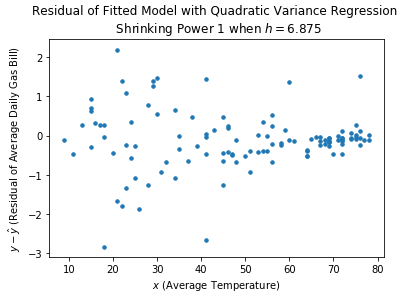

In [107]:
curr_h = 6.875
W, y_pred = linear_smoother_with_variance_regression_on_test_data(X=X, y=y, test_X=X, h=curr_h, variance_reg="quadratic", residual_power=1)
plt.scatter(X, y-y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.title('Residual of Fitted Model with Quadratic Variance Regression \n'+r' Shrinking Power 1 when $h=%.3f$' % curr_h)

Text(0.5, 1.0, 'Residual of Fitted Model with Quadratic Variance Regression \n Shrinking Power 1 when $h=6.875$')

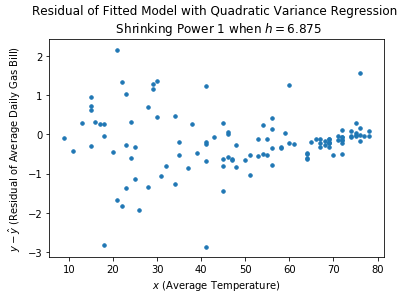

In [108]:
W, y_pred = linear_smoother_with_variance_regression_on_test_data(X=X, y=y, test_X=X, h=curr_h, variance_reg="quadratic", residual_power=2)
plt.scatter(X, y-y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.title('Residual of Fitted Model with Quadratic Variance Regression \n'+r' Shrinking Power 1 when $h=%.3f$' % curr_h)

Text(0.5, 1.0, 'Residual of Fitted Model with Linear Variance Regression \n Shrinking Power 1 when $h=6.875$')

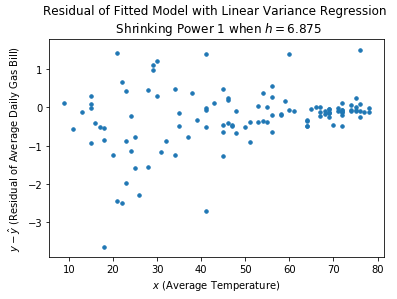

In [117]:
W, y_pred = linear_smoother_with_variance_regression_on_test_data(X=X, y=y, test_X=X, h=curr_h, variance_reg="linear", residual_power=1)
plt.scatter(X, y-y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.title('Residual of Fitted Model with Linear Variance Regression \n'+r' Shrinking Power 1 when $h=%.3f$' % curr_h)

Text(0.5, 1.0, 'Residual of Fitted Model with Linear Variance Regression \n Shrinking Power 1 when $h=6.875$')

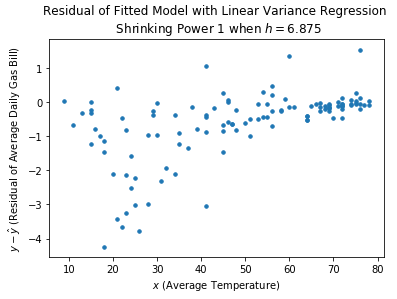

In [118]:
W, y_pred = linear_smoother_with_variance_regression_on_test_data(X=X, y=y, test_X=X, h=curr_h, variance_reg="linear", residual_power=2)
plt.scatter(X, y-y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.title('Residual of Fitted Model with Linear Variance Regression \n'+r' Shrinking Power 1 when $h=%.3f$' % curr_h)

Text(0.5, 1.0, 'Residual of Fitted Model with Original Log Squared Residual \n Shrinking Power 1 when $h=6.875$')

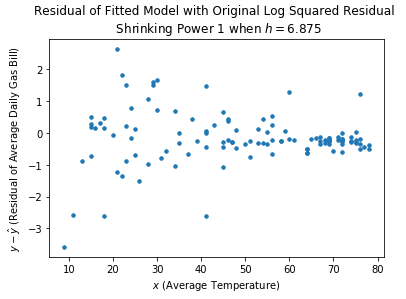

In [111]:
W, y_pred = linear_smoother_with_variance_regression_on_test_data(X=X, y=y, test_X=X, h=curr_h, variance_reg="itself", residual_power=1)
plt.scatter(X, y-y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.title('Residual of Fitted Model with Original Log Squared Residual \n'+r' Shrinking Power 1 when $h=%.3f$' % curr_h)

Text(0.5, 1.0, 'Residual of Fitted Model with Original Log Squared Residual \n Shrinking Power 1 when $h=6.875$')

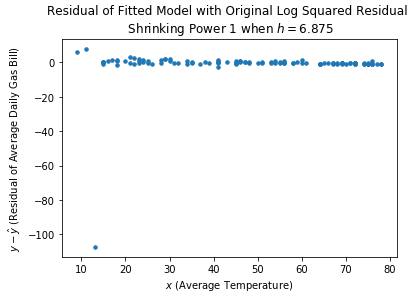

In [112]:
W, y_pred = linear_smoother_with_variance_regression_on_test_data(X=X, y=y, test_X=X, h=curr_h, variance_reg="itself", residual_power=2)
plt.scatter(X, y-y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.title('Residual of Fitted Model with Original Log Squared Residual \n'+r' Shrinking Power 1 when $h=%.3f$' % curr_h)

Text(0.5, 1.0, 'Residual of Fitted Model with Original Log Squared Residual \n Shrinking Power 1 when $h=6.875$')

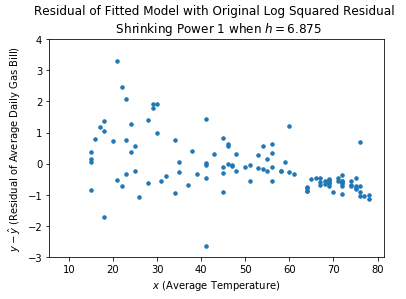

In [119]:
W, y_pred = linear_smoother_with_variance_regression_on_test_data(X=X, y=y, test_X=X, h=curr_h, variance_reg="itself", residual_power=2)
plt.scatter(X, y-y_pred, s=12)
plt.xlabel(r'$x$ (Average Temperature)')
plt.ylabel(r'$y-\hat{y}$ (Residual of Average Daily Gas Bill)')
plt.ylim(-3,4)
plt.title('Residual of Fitted Model with Original Log Squared Residual \n'+r' Shrinking Power 1 when $h=%.3f$' % curr_h)

I've implemented three different variance regression function: the linear fit, the quadratic fit, or no fit but simply using the actual (log squared) residual itself. I had a thought that why not simply use the residual itself, since the weight would only be adjusted at each training data point. Jingjing suggested that since we assume data contains noise besides the underlying data generating mechanism, fitting the (log squared) residuals to a function is a process of de-noising, and I think it makes sense. I thus implemented all, and added a variable that takes the fitted log squared residual to a power we are free to set. Out of all results (three variance regression options times power of 1 or power of 2), the heteroscedasticity issue is still prominent, and the best we could get is to shrinking the range of residuals from between $-3$ and $2$ to between $-3$ and $1$.

## Gaussian Processes
### Part (A)

Write a function that simulates a mean-zero Gaussian process on $[0,1]$ under the Matern$(5/2)$ covariance function. The function will accept as arguments: 

(1) ﬁnite set of points $x_1,\dots,x_N$ on the unit interval; 

(2) a triplet $(b,\tau_1^2,\tau_2^2)$. 

It will return the value of the random process at each point: $f(x_1),\dots,f(x_N)$.

Use your function to simulate (and plot) Gaussian processes across a range of values for $b,\tau_1^2,\tau_2^2$.

We implement two covariance functions:

* $\textbf{Squared exponential covariance function}$
$$C_{SE}(x_1,x_2)=\tau_1^2\exp\Big\{-\frac{1}{2}\Big(\frac{d}{b}\Big)^2\Big\}+\tau_2^2 \delta(x_1,x_2)$$ in which $$\delta(x_1,x_2)=\mathbb{1}(x_1=x_2)$$ and $$d=\vert\vert x_1-x_2\vert\vert_2$$

* $\textbf{Matern(5/2) covariance function}$
$$C_{M52}(x_1,x_2)=\tau_1^2\Big\{1+\frac{\sqrt{5}d}{b}+\frac{5d^2}{3b^2}\Big\}\exp\Big(\frac{-\sqrt{5}d}{b}\Big)+\tau_2^2 \delta(x_1,x_2)$$

From the question we have that the Gaussian process would give us $$[f(x_1),\dots,f(x_N)]^T\sim \mathcal{MVN}(\mathbf{0},\mathbf{C})$$ in which $$\mathbf{C}(i,j)=cov\big(f(x_1),f(x_2)\big)=C(x_1,x_2)$$

(side note: $f(x_1)$, $f(x_2)$ are only related to $x_1,x_2$ in terms of their distance.)

To simulate $[f(x_1),\dots,f(x_N)]$, we could either directly sample from $\mathcal{MVN}(\mathbf{0},\mathbf{C})$ distribution, or use our finding from Exercise $1$ $\textbf{The multivariate normal distribution}$ $\textit{Basics}$ Part (E): simulate $z_{N\times 1}\sim \mathcal{MVN}(\mathbf{0},\mathbf{I})$ distribution, and apply affine transformation $\mathbf{Lz}$, in which $\mathbf{LL^T}=\mathbf{C}$ and can be achieved through Cholesky decomposition of $\mathbf{C}$.

When $b\to 0$, we have i.i.d. samples from normal distribution; when $b\to 1$, we have the exact same variance between each pair of data points.

In [3]:
def compute_covariance_matrix(distance_matrix, b, tau_1_sqd, tau_2_sqd, cov_func, new_data=False):
    """Compute the covariance matrix given an array of a finite set of points.
    
    Args:
        distance_matrix: a N-by-N matrix whose i,j-th entry is the Euclidean distance between data point x_i and x_j.
        b: one of the parameters in covariance function.
        tau_1_sqd: one of the parameters in covariance function.
        tau_2_sqd: one of the parameters in covariance function.
        cov_func: a string of covariance function name; currently have options "se" (squared exponential)
                  and "m52" (Matern 5/2).
        new_data: a boolean variable indicating whether the distance matrix calculates the distances beween training and new data.
                  if it is so, then we don't need to include the term with tau_2_sqd, because conceptually speaking we shall not 
                  have x_1==x_2 in thus case.
                  
    Returns:
        a N-by-N matrix whose i,j-th entry is the covariance between data point x_i and x_j.
    """
    if cov_func == 'se':
        # note that Kronecker delta function would equal to 1 only when i=j, thus we only add tau_2_sqd at the diagonals
        # of covariance matrix by constructing a diagonal matrix using np.eye()
        cov_matrix = tau_1_sqd*np.exp(-.5*np.power(distance_matrix/b,2))+tau_2_sqd*np.eye(distance_matrix.shape[0]) if new_data==False \
                        else tau_1_sqd*np.exp(-.5*np.power(distance_matrix/b,2))
    elif cov_func == 'm52':
        cov_matrix = tau_1_sqd*(1+np.sqrt(5.)*(distance_matrix/b)+ \
                                5./3*np.power(distance_matrix/b, 2))*np.exp(-np.sqrt(5.)*(distance_matrix/b)) \
                                +tau_2_sqd*np.eye(distance_matrix.shape[0]) if new_data==False \
                        else tau_1_sqd*(1+np.sqrt(5.)*(distance_matrix/b)+ \
                                5./3*np.power(distance_matrix/b, 2))*np.exp(-np.sqrt(5.)*(distance_matrix/b))
    else:
        raise ValueError("Do not have this option of covariance function.")
    return cov_matrix

def Gaussian_process(X, b, tau_1_sqd, tau_2_sqd, cov_func, seed, n=1):
    """Simulate Gaussian process at each point in array X.
    
    Args:
        X: an array of a finite set of points x_1 through x_N.
        b: one of the parameters in covariance function.
        tau_1_sqd: one of the parameters in covariance function.
        tau_2_sqd: one of the parameters in covariance function.
        cov_func: a string of covariance function name; currently have options "se" (squared exponential)
                  and "m52" (Matern 5/2).
        seed: the value of random seed.
        n: number of MVN samples.
                  
    Returns:
        if n==1: an array of values of Gaussian process at each point of x_1 through x_N;
        if n>1: each column is an array of simulated Gaussian process values.
    """
    distance_matrix = np.abs(X.reshape(-1,1)-X) # X.reshape(-1,1) makes the original 1d array into a column vector
    cov_matrix = compute_covariance_matrix(distance_matrix, b, tau_1_sqd, tau_2_sqd, cov_func)
    np.random.seed(seed)
    return sps.multivariate_normal.rvs(mean=np.zeros(X.shape[0]), cov=cov_matrix, size=n).T

def make_one_plot_of_multiple_Gaussian_processes_of_same_parameters(X, parameters_list):
    """Simulate certain number of Gaussian processes with the same set of hyperparameters b, tau_1_sqd, tau_2_sqd and covariance function,
       and plot them in the same graph.
    
    Args:
        X: an array of a finite set of points x_1 through x_N.
        parameters_list: a list of hyperparameters [b, tau_1_sqd, tau_2_sqd, cov_func, seed, n].
                  
    Returns:
        no return variable; simply making the plot.
    """
    simulated_gps = Gaussian_process(X, *parameters_list)
    for i in range(parameters_list[-1]):
        plt.plot(X,simulated_gps[:,i])
    plt.xlabel("X")
    plt.ylabel("f(X)")
    plt.title(("%s Gaussian processes with \n"+r"$b=$%s, $\tau_1^2=$%s, $\tau_2^2=$%s"+ "\n and covariance function %s") % \
          (str(parameters_list[-1]),str(parameters_list[0]),str(parameters_list[1]),str(parameters_list[2]),parameters_list[3]))
    
def make_multiple_gp_plots(X, panel_dimension, list_of_parameter_lists):
    """Make multiple plots for simulated Gaussian processes with selected combinations of hyperparameters, usually fixing all but one 
       in order to see the role of these hyperparameters.
    Args:
        X: an array of a finite set of points x_1 through x_N.
        panel_dimension: a list of the values indicating the dimension of the plots.
        parameters_list: a list of hyperparameter lists, each of which is a list of hyperparameters [b, tau_1_sqd, tau_2_sqd, cov_func, seed, n].
                  
    Returns:
        no return variable; simply making the plot.
    """
    fig = plt.figure(figsize=(24,14))
    fig.subplots_adjust(hspace=0.3)
    for idx, parameters_list in enumerate(list_of_parameter_lists):
        simulated_gps = Gaussian_process(X, *parameters_list)
        ax = fig.add_subplot(panel_dimension[0], panel_dimension[1], idx+1)
        for i in range(parameters_list[-1]):
            ax.plot(X, simulated_gps[:,i])
        ax.set_xlabel("X")
        ax.set_ylabel("f(X)")
        ax.set_ylim(top=4, bottom=-4)
        ax.set_title(("%s Gaussian processes with \n"+r"$b=$%s, $\tau_1^2=$%s, $\tau_2^2=$%s"+ "\n and covariance function %s") % \
              (str(parameters_list[-1]),str(parameters_list[0]),str(parameters_list[1]),str(parameters_list[2]),parameters_list[3]))

In [6]:
# get N equidistant points in unit interval
N=500
X = np.linspace(0., 1., N)

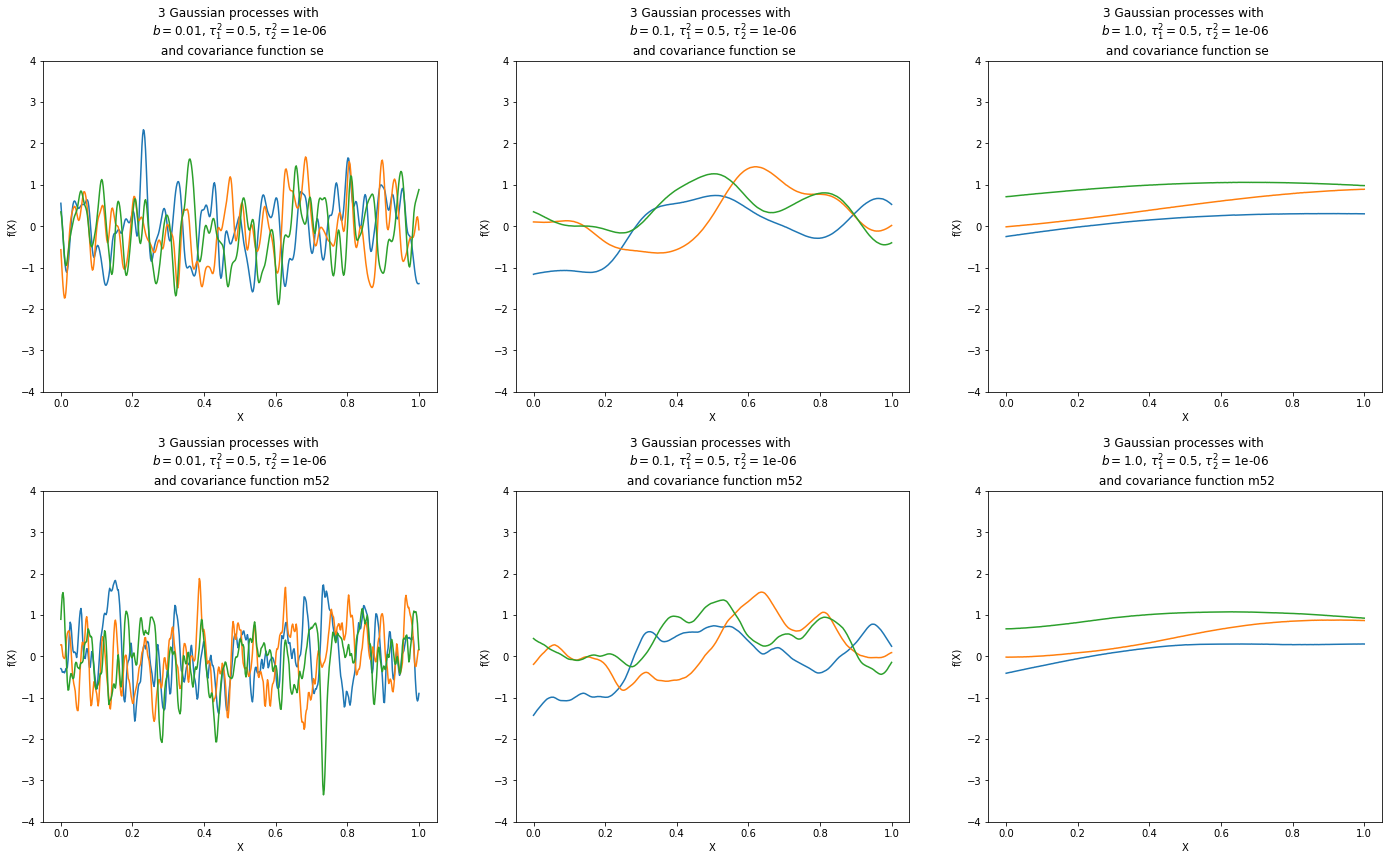

In [7]:
investigate_b_list = [[.01,.5,1e-6,'se',2019,3], [.1,.5,1e-6,'se',2019,3], [1.,.5,1e-6,'se',2019,3], \
                     [.01,.5,1e-6,'m52',2019,3], [.1,.5,1e-6,'m52',2019,3], [1.,.5,1e-6,'m52',2019,3]]
make_multiple_gp_plots(X=X, panel_dimension=[2,3], list_of_parameter_lists=investigate_b_list)

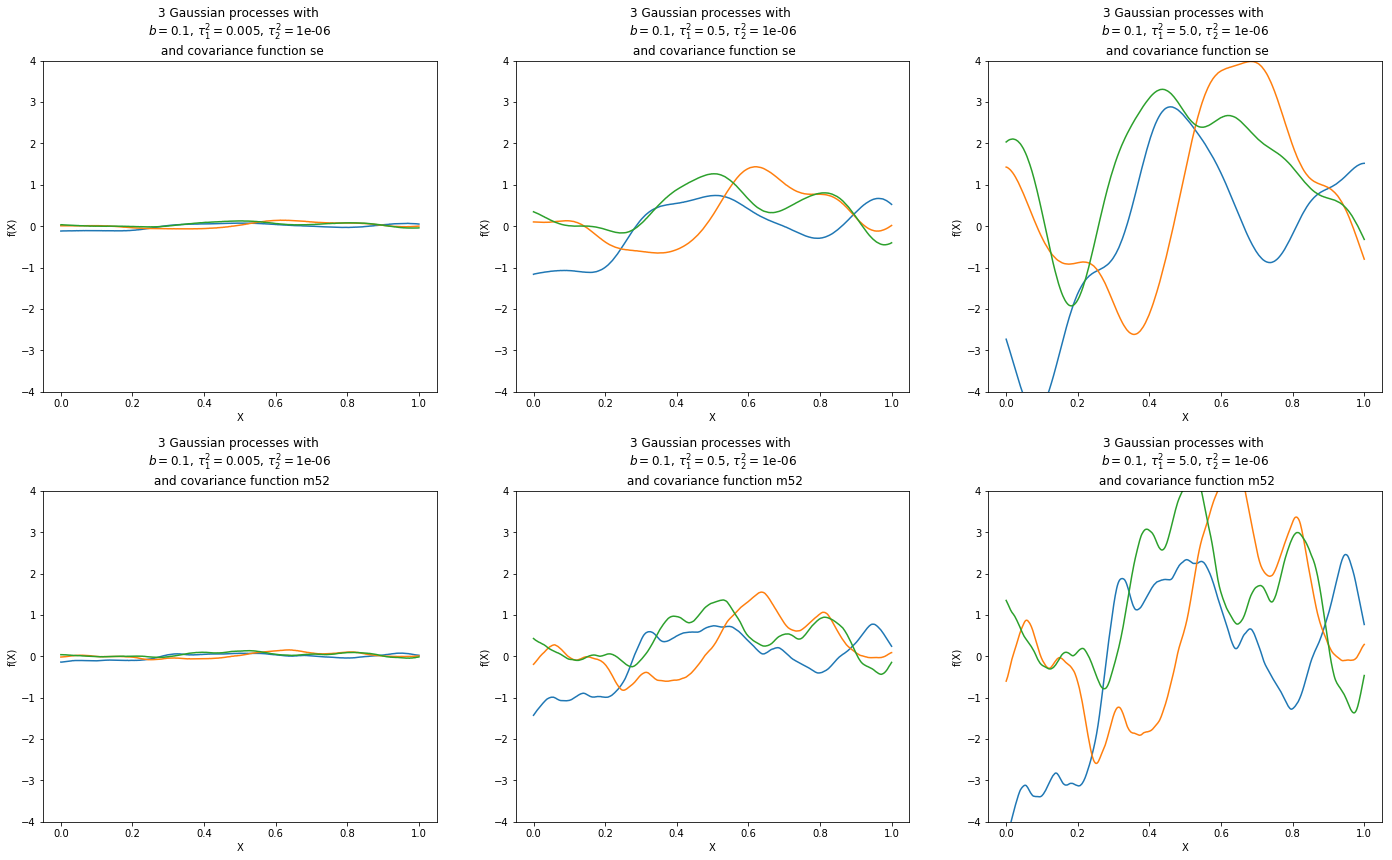

In [8]:
investigate_tau_1_sqd_list = [[.1,.005,1e-6,'se',2019,3], [.1,.5,1e-6,'se',2019,3], [.1,5.,1e-6,'se',2019,3], \
                     [.1,.005,1e-6,'m52',2019,3], [.1,.5,1e-6,'m52',2019,3], [.1,5.,1e-6,'m52',2019,3]]
make_multiple_gp_plots(X=X, panel_dimension=[2,3], list_of_parameter_lists=investigate_tau_1_sqd_list)

/Users/EJ/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/_multivariate.py:652: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


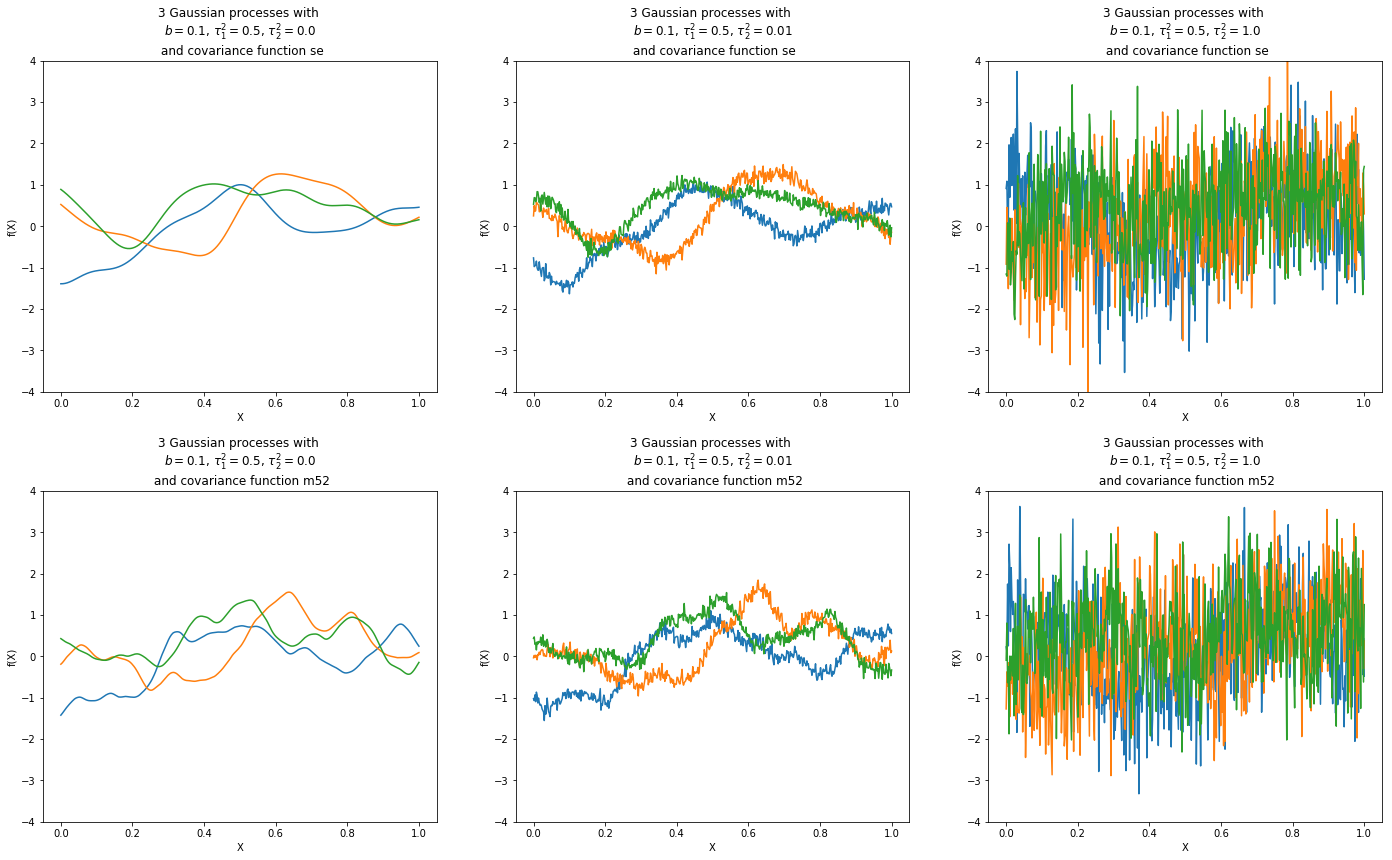

In [14]:
investigate_tau_2_sqd_list = [[.1,.5,0.,'se',2019,3], [.1,.5,1e-2,'se',2019,3], [.1,.5,1.,'se',2019,3], \
                     [.1,.5,0.,'m52',2019,3], [.1,.5,1e-2,'m52',2019,3], [.1,.5,1.,'m52',2019,3]]
make_multiple_gp_plots(X=X, panel_dimension=[2,3], list_of_parameter_lists=investigate_tau_2_sqd_list)

From above three plots, each of which contains six sub-plots with $3$ in the first row from squared exponential covariance function, and $3$ in the second row from Matern $5/2$ covariance function. We observed the role of each hyperparameter as follows:

* $b$

controls the "frequency" of the Gaussian process: as $b$ increases, the curve fluctuates less and less frequently, while the range of samples stays consistent. Notice that under the same hyperparameter settings, "M52" (Matern(5/2)) tends to be less smooth as "se" (squared subexponential) covariance function, as we can notice small jump/disturbance in the former. It has been pointed out during the lecture such that squared subexponential function is infinitely differentiable, while Matern(5/2) doesn't have continuous $2$-nd order derivative, thus could have sudden shift in change rate.

* $\tau_1^2$

controls the "amplitude" of the Gaussian process: as $\tau_1^2$ increases, the range of the process becomes larger and larger.

* $\tau_2^2$

controls the noise level at each point: as $\tau_2^2$ increases, the process keeps the exact same shape/trend under each covariance function, but the fluctuation within each small neighborhood becomes more and more prominent.

It's worth pointing out that I set a constant random seed among all simulations, therefore we can observe generally similar trends of each of the three curves when comparing the exact same setting of hyperparameters except the choice of covariance function.

## In Nonparametric Regression and Spatial Smoothing 
### Part (C)

Our conclusion from Part (B): $$f(x^*)\vert \mathbf{y_{1:N}}\sim\mathcal{MVN}\Big(\mathbf{C_{*.}}(\mathbf{C_{..}}+\sigma^2\mathbf{I})^{-1}\mathbf{y}, \mathbf{C_{**}}-\mathbf{C_{*.}}(\mathbf{C_{..}}+\sigma^2\mathbf{I})^{-1}\mathbf{C_{*.}^T}\Big)$$

However, since the question asks about the posterior mean and CI on $\textbf{observed}$ data points, we need to use our conclusion on Part (A) $$f(X_{1:N})\vert \mathbf{y_{1:N}}\sim\mathcal{MVN}\Big(\sigma^{-2}(\sigma^{-2}\mathbf{I}+\mathbf{C_{..}}^{-1})^{-1}\mathbf{y}, (\sigma^{-2}\mathbf{I}+\mathbf{C_{..}}^{-1})^{-1}\Big)$$

setting the known variance of noise to be $\sigma^2=1$.

In [4]:
def pointwise_confidence_interval_Gaussian_process(X, y, sigma2, b, tau_1_sqd, tau_2_sqd, cov_func, data="observed", critical_value_97point5=1.96):
    """Simulate Gaussian process at each point in array X.
    
    Args:
        X: an array of a finite set of points x_1 through x_N.
        y: an array of response variable for X's.
        sigma2: variance of noise term.
        b: one of the parameters in covariance function.
        tau_1_sqd: one of the parameters in covariance function.
        tau_2_sqd: one of the parameters in covariance function.
        cov_func: a string of covariance function name; currently have options "se" (squared exponential)
                  and "m52" (Matern 5/2).
        data: a string indicating whether we are computing the posterior mean and CI for "new" data or "observed" data.
        critical_value_97point5: 97.5 percentile critical value.
                  
    Returns:
        if n==1: an array of values of Gaussian process at each point of x_1 through x_N;
        if n>1: each column is an array of simulated Gaussian process values.
    """
    distance_matrix = np.abs(X.reshape(-1,1)-X) # X.reshape(-1,1) makes the original 1d array into a column vector
    N = X.shape[0]
    if data=="new":
        None
#         pointwise_mean = np.array([*map(lambda i: (cov_matrix[i].reshape(1,-1))@(np.linalg.inv(cov_matrix \
#                                                                 +sigma2*np.identity(N)))@y, np.arange(N))])[:,0]
#         pointwise_var = np.array([*map(lambda i: (cov_matrix[i,i]-(cov_matrix[i].reshape(1,-1))@(np.linalg.inv(cov_matrix \
#                                             +sigma2*np.identity(N)))@(cov_matrix[i].reshape(-1,1)))[0,0], np.arange(N))])
    elif data=="observed":
        C_dotdot = compute_covariance_matrix(distance_matrix, b, tau_1_sqd, tau_2_sqd, cov_func)
        # adding "+1e-10*np.identity(X.shape[0])" in the inverse of C_dotdot in order to avoid Singular Matrix error
        pointwise_var = np.linalg.inv(1./sigma2*np.identity(X.shape[0])+np.linalg.inv(C_dotdot+1e-10*np.identity(X.shape[0])))
        pointwise_mean = 1./sigma2*pointwise_var@y
    else:
        raise ValueError("Do not have this data option.")
    upper_bound = pointwise_mean+critical_value_97point5*np.sqrt(np.diag(pointwise_var))
    lower_bound = pointwise_mean-critical_value_97point5*np.sqrt(np.diag(pointwise_var))
    plt.scatter(X, y, label='observed', s=12, color='black',alpha=.6)
    plt.scatter(X, pointwise_mean, label='posterior mean', s=12, color='aqua')
    plt.vlines(x=X, ymin=lower_bound, ymax=upper_bound, colors='r', linestyles='solid', label=r'$95\% CI$', alpha=.5)
    #plt.fill_between(x=X, y1=lower_bound, y2=upper_bound, facecolor='grey', alpha=0.5, label=r'$95\% CI$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Average Temperature')
    plt.ylabel('Average Daily Gas Bill')
    plt.title(r'$95\%$ '+'Confidence Interval for Gaussian Process Posterior Smoother \n' + r'with $b=$%s, $\tau_1^2$=%s, $\tau_2^2$=%s'% \
              (str(b), str(tau_1_sqd), str(tau_2_sqd)))

In [59]:
# continue to use utilities dataset because cannot find ethanol.csv
utilities_df=pd.read_csv('utilities.csv')
X = np.array(utilities_df['temp'])*1. # average temperature
y = np.array(utilities_df['gasbill']/utilities_df['billingdays']) # average daily gas bill

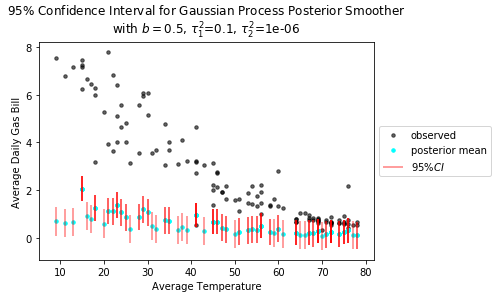

In [83]:
pointwise_confidence_interval_Gaussian_process(X, y, sigma2, .5, .1, 1e-6, cov_func="se")

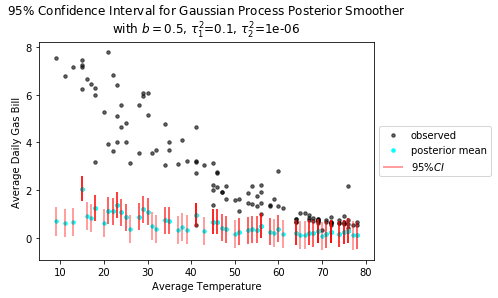

In [84]:
pointwise_confidence_interval_Gaussian_process(X, y, sigma2, .5, .1, 1e-6, cov_func="m52")

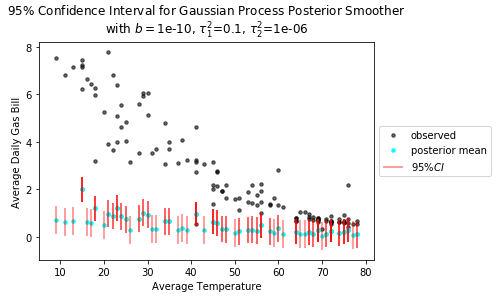

In [85]:
pointwise_confidence_interval_Gaussian_process(X, y, sigma2, 1e-10, .1, 1e-6, cov_func="se")

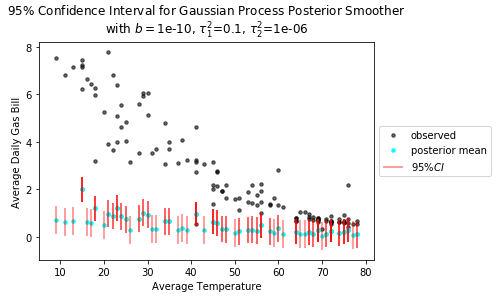

In [86]:
pointwise_confidence_interval_Gaussian_process(X, y, sigma2, 1e-10, .1, 1e-6, cov_func="m52")

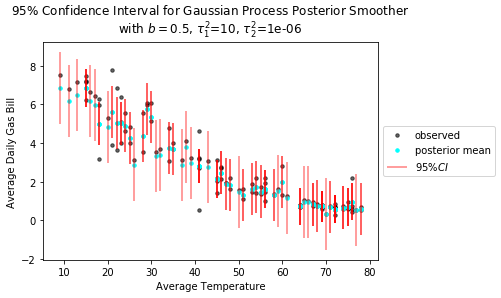

In [87]:
pointwise_confidence_interval_Gaussian_process(X, y, sigma2, .5, 10, 1e-6, cov_func="se")

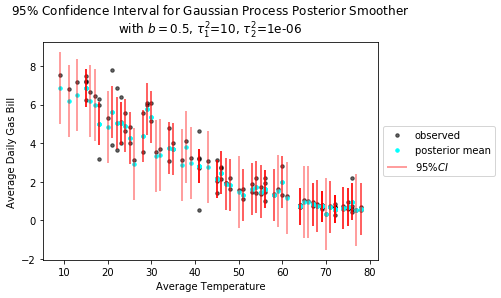

In [88]:
pointwise_confidence_interval_Gaussian_process(X, y, sigma2, .5, 10, 1e-6, cov_func="m52")

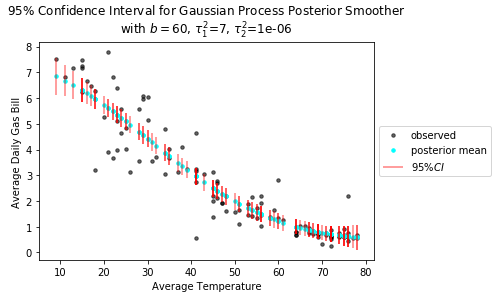

In [89]:
pointwise_confidence_interval_Gaussian_process(X, y, sigma2, 60, 7, 1e-6, cov_func="m52")

We observe that when $\tau_2^2$ is small, the value of $b$ doesn't affect the fit at all, but the value of $\tau_1^2$ greatly affects the fit. We observe a quite good fit when $\tau_1^2=10$. Note that some confidence bands have darker color, since there are multiple data having the same average temperature, thus the bands overlapped.

### Part (E)

Fix $\tau_2^2 = 0$, and evaluate the log of the marginal likelihood function $p(\mathbf{y} | \tau_1^2, b)$ over a discrete $2$-d grid of points.

We continue to use utilities dataset, as we cannot find ethanol dataset:

In [5]:
def compute_log_marginal_likelihood(y, distance_matrix, b, tau_1_sqd, tau_2_sqd, sigma2, cov_func="m52"):
    """Compute the log of marginal likelihood of y given b and tau_1_sqd, while setting tau_2_sqd to 0.
    
    Args:
        y: an array of response variable for X's.
        distance_matrix: a N-by-N matrix whose i,j-th entry is the Euclidean distance between data point x_i and x_j.
        b: one of the parameters in covariance function.
        tau_1_sqd: one of the parameters in covariance function.
        tau_2_sqd: one of the parameters in covariance function.
        sigma2: variance of noise term.
        cov_func: a string of covariance function name; currently have options "se" (squared exponential)
                  and "m52" (Matern 5/2).
        
    Returns:
        a scalar of log marginal likelihood for array y.
    """
    cov_matrix = compute_covariance_matrix(distance_matrix=distance_matrix, b=b, tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, cov_func=cov_func)
    return sps.multivariate_normal.logpdf(y, mean=np.zeros(y.shape[0]), cov=cov_matrix+sigma2*np.identity(y.shape[0]))

def make_contour_plot_and_select_best_hyperparameters(X, y, sigma2, b_lower, b_upper, tau_1_sqd_lower, tau_1_sqd_upper, tau_2_sqd, granularity, cov_func="m52"):
    """Make a contour plot for computed log marginal likelihood of y over a 2d grid of hyperparameter points ((tau_1_sqd, b)'s),
       and return the best pair of hyperparameters (tau_1_sqd_hat, b_hat) in terms of the largest marginal log-likelihood of y.
       
    Args:
        X: an array of a finite set of points x_1 through x_N.
        y: an array of response variable for X's.
        sigma2: variance of noise term.
        b_lower: the lower bound of b
        b_upper: the upper bound of b
        tau_1_sqd_lower: the lower bound of tau_1_sqd
        tau_1_sqd_upper: the upper bound of tau_1_sqd
        tau_2_sqd: one of the parameters in covariance function.
        granularity: the granularity of the tuning hyperparameter, indicated by the number of points in the range of hyperparameter
                     that we are computing the log-likelihood for.
        cov_func: a string of covariance function name; currently have options "se" (squared exponential)
                  and "m52" (Matern 5/2).
    
    Returns:
        two scalars of the best tau_1_sqd and b.
    """
    # compute pair-wise distances among points in y:
    distance_matrix = np.abs(X.reshape(-1,1)-X) # X.reshape(-1,1) makes the original 1d array into a column vector
    tau_1_sqd_range = np.linspace(tau_1_sqd_lower, tau_1_sqd_upper, granularity)
    b_range = np.linspace(b_lower, b_upper, granularity)
    tau1sqrd_grid, b_grid = np.meshgrid(tau_1_sqd_range, b_range)

    log_marginal_likelihood_matrix = np.array([compute_log_marginal_likelihood(y=y, distance_matrix=distance_matrix, \
                                    b=b, tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, sigma2=sigma2, cov_func=cov_func) \
                                            for (tau_1_sqd, b) in zip(tau1sqrd_grid.T.ravel(), b_grid.T.ravel())]).reshape(tau1sqrd_grid.T.shape)
    # or we can compute the log marginal likelihood by using the following alternative form, which code-wise is easier to understand compared to above line:
    # alt_tau_1_sqd_grid = np.linspace(tau_1_sqd_lower, tau_1_sqd_upper, granularity)
    # alt_b_grid = np.linspace(b_lower, b_upper, granularity)
    # alt_log_likelihood = np.array([[compute_log_marginal_likelihood(y, b, tau_1_sqd, sigma2) for tau_1_sqd in alt_tau_1_sqd_grid] for b in alt_b_grid])
    contour_plot = plt.contourf(tau1sqrd_grid.T, b_grid.T, log_marginal_likelihood_matrix)
    plt.colorbar(contour_plot)
    plt.xlabel(r'$\tau_1^2$')
    plt.ylabel(r'$b$')
    plt.title('Contour Plot for Hyperparameter Tuning w.r.t. Marginal Log-Likelihood')
    best_tau_1_sqd_idx, best_b_idx = list(zip(*np.where(log_marginal_likelihood_matrix==np.max(log_marginal_likelihood_matrix))))[0]
    best_tau_1_sqd, best_b = tau_1_sqd_range[best_tau_1_sqd_idx], b_range[best_b_idx]
    plt.scatter(best_tau_1_sqd, best_b, color='red', s=12)
    print(r'The largest marginal log-likelihood is about %.2f, given by $\tau_1^2\approx$ %.2f and $b\approx$ %.2f' % \
                  (np.max(log_marginal_likelihood_matrix), best_tau_1_sqd, best_b))
    return best_tau_1_sqd, best_b

The largest marginal log-likelihood is about -145.15, given by $\tau_1^2\approx$ 58.00 and $b\approx$ 112.63


(58.0, 112.62626262626263)

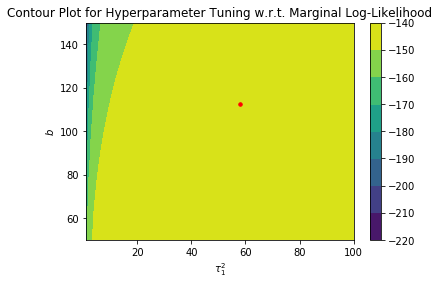

In [93]:
sigma2=.75
tau_1_sqd_hat, b_hat = make_contour_plot_and_select_best_hyperparameters(X=X, y=y, sigma2=sigma2, \
    b_lower=50., b_upper=150., tau_1_sqd_lower=1., tau_1_sqd_upper=100., tau_2_sqd=1e-6, granularity=100, cov_func="m52")
tau_1_sqd_hat, b_hat

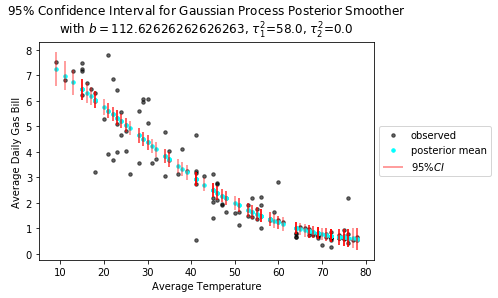

In [94]:
pointwise_confidence_interval_Gaussian_process(X=X, y=y, sigma2=sigma2, b=b_hat, tau_1_sqd=tau_1_sqd_hat, tau_2_sqd=0., cov_func="m52")

The largest marginal log-likelihood is about -144.73, given by $\tau_1^2\approx$ 42.22 and $b\approx$ 63.18


(42.22222222222223, 63.18181818181819)

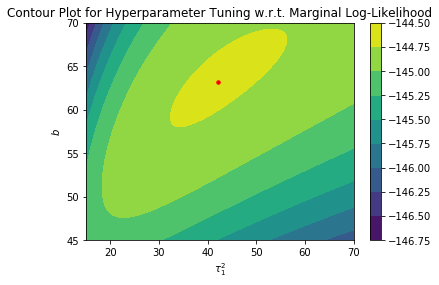

In [95]:
sigma2=.75
tau_1_sqd_hat, b_hat = make_contour_plot_and_select_best_hyperparameters(X=X, y=y, sigma2=sigma2, \
    b_lower=45., b_upper=70., tau_1_sqd_lower=15., tau_1_sqd_upper=70., tau_2_sqd=1e-6, granularity=100, cov_func="se")
tau_1_sqd_hat, b_hat

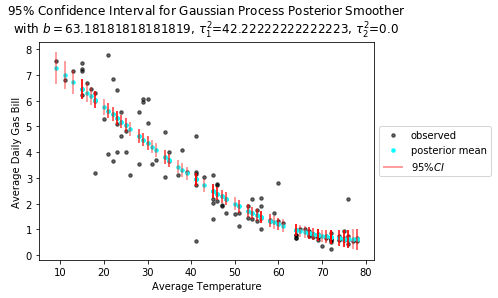

In [96]:
pointwise_confidence_interval_Gaussian_process(X=X, y=y, sigma2=sigma2, b=b_hat, tau_1_sqd=tau_1_sqd_hat, tau_2_sqd=0., cov_func="se")

The largest marginal log-likelihood is about -144.73, given by $\tau_1^2\approx$ 42.12 and $b\approx$ 63.74


(42.121212121212125, 63.73737373737374)

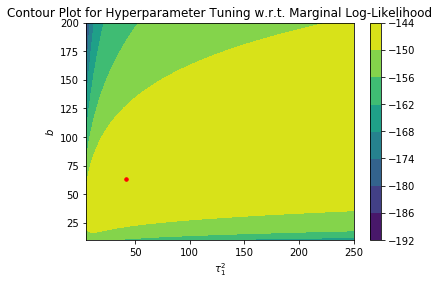

In [97]:
sigma2=.75
tau_1_sqd_hat, b_hat = make_contour_plot_and_select_best_hyperparameters(X=X, y=y, sigma2=sigma2, \
    b_lower=10., b_upper=200., tau_1_sqd_lower=5., tau_1_sqd_upper=250., tau_2_sqd=1e-6, granularity=100, cov_func="se")
tau_1_sqd_hat, b_hat

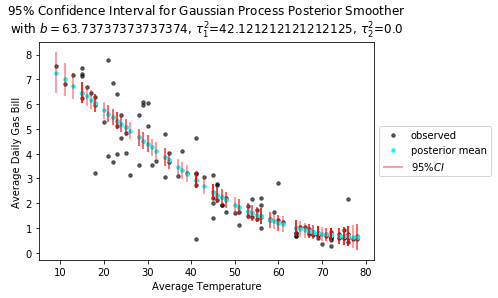

In [98]:
pointwise_confidence_interval_Gaussian_process(X=X, y=y, sigma2=sigma2, b=b_hat, tau_1_sqd=tau_1_sqd_hat, tau_2_sqd=0., cov_func="m52")

The largest marginal log-likelihood is about -152.83, given by $\tau_1^2\approx$ 6.00 and $b\approx$ 51.01


(6.0, 51.01010101010101)

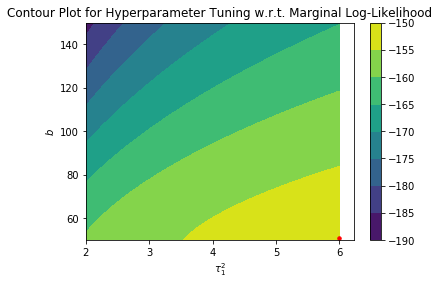

In [71]:
sigma2=1.
tau_1_sqd_hat, b_hat = make_contour_plot_and_select_best_hyperparameters(X=X, y=y, sigma2=sigma2, \
                    b_lower=50., b_upper=150., tau_1_sqd_lower=2., tau_1_sqd_upper=6., tau_2_sqd=0., granularity=100)
tau_1_sqd_hat, b_hat

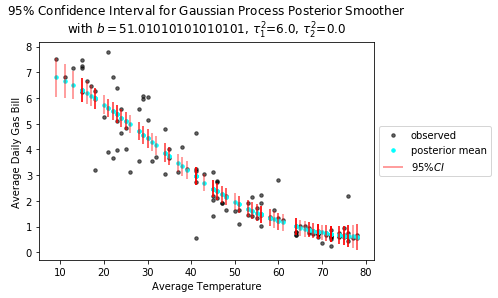

In [80]:
pointwise_confidence_interval_Gaussian_process(X=X, y=y, sigma2=sigma2, b=b_hat, tau_1_sqd=tau_1_sqd_hat, tau_2_sqd=0., cov_func="m52")

The largest marginal log-likelihood is about -150.68, given by $\tau_1^2\approx$ 43.28 and $b\approx$ 100.00
43.282828282828284 100.0


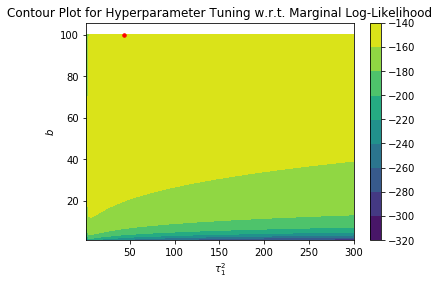

In [90]:
sigma2=1.
tau_1_sqd_hat, b_hat = make_contour_plot_and_select_best_hyperparameters(X=X, y=y, sigma2=sigma2, \
                        b_lower=1., b_upper=100., tau_1_sqd_lower=1., tau_1_sqd_upper=300., tau_2_sqd=0., granularity=100)
print(tau_1_sqd_hat, b_hat)

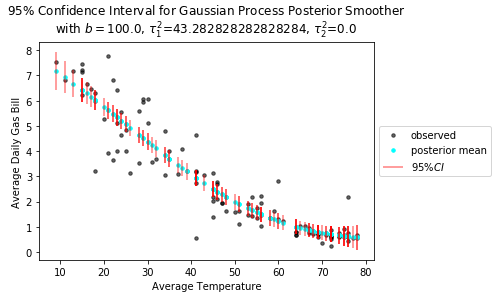

In [91]:
pointwise_confidence_interval_Gaussian_process(X=X, y=y, sigma2=sigma2, b=b_hat, tau_1_sqd=tau_1_sqd_hat, tau_2_sqd=0., cov_func="m52")

We observe that after tuning the hyperparameters $\tau_1^2$ and $b$ on a $2$-d grid, the confidence interval becomes narrower and the fit becomes more smooth.

Note that we set $\sigma^2=0.75$ or $\sigma^2=1$ in every case. This needs to be fixed for comparison. Larger $\sigma^2$ naturally leads to wider confidence interval.

We note that the optimal values of $b$ and $\tau_1^2$ are drastically different depending on different choices of $\sigma^2$ and covariance functions.

Also, over a wide range of $b$ and $\tau_1^2$, the change in marginal log-likelihood is very small. This indicates that the variances of $b$ and $\tau_1^2$ are big -- notice that, a pointwise choice of optimal values for $b$ and $\tau_1^2$ like what we are doing here forfeits the estimate of variances, thus if the likelihood has a relatively flat shape, a point estimate might not convey the whole idea of these parameters.

### Part (F)

For this question, we compute for $f$ for every point (up to certain grandularity) in the $2$-d grid, and most of them if not all shall be a new point that the dataset doesn't contain. We thus use our conclusion from Part (B) to compute posterior mean and posterior standard deviation: $$f(\mathbf{x^*})\vert \mathbf{y_{1:N}}\sim\mathcal{MVN}\Big(\mathbf{C_{*.}}(\mathbf{C_{..}}+\sigma^2\mathbf{I})^{-1}\mathbf{y}, \mathbf{C_{**}}-\mathbf{C_{*.}}(\mathbf{C_{..}}+\sigma^2\mathbf{I})^{-1}\mathbf{C_{*.}^T}\Big)$$

in which $\mathbf{x^*}=(x_{\text{lon}}, x_{\text{lat}})$ is the data point in terms of the coordinate of longitude and latitude, and the posterior variance of $x_i^*$ is the $i,i$-th element of the posterior covariance matrix.

Meanwhile, to tune the hyperperameters $\tau_1^2,b_1,b_2$, we do the same thing as Part (E): we use the marginal log-likelihood of $\mathbf{y_{1:N}}$, whose distribution is derived by directly using the conclusion from *Conditionals and Marginals* in **Exercise 1**:

$$\mathbf{y_{1:N}}\sim\mathcal{MCN}\big(\mathbf{0}, \mathbf{C_{..}}\big)$$

In [7]:
# continue to use utilities dataset because cannot find ethanol.csv
weather_df=pd.read_csv('weather.csv')
lon = np.array(weather_df['lon'])
lat = np.array(weather_df['lat'])
pressure = np.array(weather_df['pressure'])
temperature = np.array(weather_df['temperature'])

In [8]:
np.min(lon), np.max(lon)

(-131.0, -114.883331298828)

In [9]:
np.min(lat), np.max(lat)

(40.826389312744105, 51.66999816894529)

To calculate Euclidean distance or nonisotropic distance, we can calculate the distance matrix on each of longitude and latitude dimension, and the sum of their element-wise squared version is the squared distance of two points.

In [134]:
def nonisotropic_distance_matrix(lon1, lon2, lat1, lat2, b1, b2):
    """Compute the nonisotropic distance matrix, each of whose entries is the pair-wise distance between two points.
    
    Args:
        lon1: the longitude vector whose length is the same as the number of rows for the distance matrix.
        lon2: the longitude vector whose length is the same as the number of columns for the distance matrix.
        lat1: the latitude vector whose length is the same as the number of rows for the distance matrix.
        lat2: the latitude vector whose length is the same as the number of columns for the distance matrix.
        b1: normalizing constant for longitude dimension.
        b2: normalizing constant for latitude dimension.
        
    Returns:
        a 2d numpy array which is the nonisotropic distance matrix --  if both b1 and b2 are 1, it gives the
        Euclidean distance matrix.
    """
    # calculate distance matrix on lon dimension and lat dimension
    lon_distance_matrix = np.abs(lon1.reshape(-1,1)-lon2)
    lat_distance_matrix = np.abs(lat1.reshape(-1,1)-lat2)
    return np.sqrt(np.power(lon_distance_matrix/b1,2)+np.power(lat_distance_matrix/2,2))

def compute_log_marginal_likelihood_2d(y, lon, lat, b1, b2, tau_1_sqd, tau_2_sqd, sigma2, cov_func="m52"):
    """Compute the log of marginal likelihood of y given b1, b2 and tau_1_sqd, while setting tau_2_sqd fixed.
    
    Args:
        Args:
        y: an array of response variable for X's.
        lon: an array of independent variable longitude.
        lat: an array of independent variable latitude.
        b1: one of the parameters in nonisotropic function.
        b2: one of the parameters in nonisotropic function.
        tau_1_sqd: one of the parameters in covariance function.
        tau_2_sqd: one of the parameters in covariance function.
        sigma2: variance of noise term.
        cov_func: a string of covariance function name; currently have options "se" (squared exponential)
                  and "m52" (Matern 5/2).
        
    Returns:
        a scalar of log marginal likelihood for array y.
    """
    lon_new_points = np.linspace(np.min(lon), np.max(lon), granularity)
    lat_new_points = np.linspace(np.min(lat), np.max(lat), granularity)
    distance_matrix_dotdot = nonisotropic_distance_matrix(lon1=lon, lon2=lon, lat1=lat, lat2=lat, b1=b1, b2=b2)
    C_dotdot = compute_covariance_matrix(distance_matrix=distance_matrix_dotdot, b=1., tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, cov_func=cov_func)
    return sps.multivariate_normal.logpdf(y, mean=np.zeros(y.shape[0]), cov=C_dotdot+sigma2*np.identity(y.shape[0]))

def Nelder_Mead_objective_function(x):
    """Write objective function for Nelder-Mead optimization over combination of hyperparameters [b1, b2, tau_1_sqd], replacing the grid-search 
       with contour plot method implemented for Part (E). Need to specify other parameters besides these three hyperparameters, and x is a list/array 
       that contains only the parameters to be optimized. Also, the optimization is meant to minimize the given function, but our goal is to maximize
       the log-likelihood which is always less than 0, thus we put a negative sign in front to achieve the optimization direction.
       
       Args:
           x: a list/array contains [b1, b2, tau_1_sqd]
           
       Returns:
           negative log-likelihood
    
    """
    
    b1, b2, tau_1_sqd = x[0], x[1], x[2]
    return -compute_log_marginal_likelihood_2d(y=current_y, lon=lon, lat=lat, b1=b1, b2=b2, tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, \
                                               sigma2=empirical_sigma2, cov_func=cov_function)

def compute_predictive_mean_and_variance(y, lon, lat, b1, b2, tau_1_sqd, tau_2_sqd, sigma2, granularity, cov_func="m52"):
    """Compute the mean and variance from the posterior predictive distribution of the new points on a 2-d grid, given b1, b2 and tau_1_sqd, 
       while specifying the value of tau_2_sqd and covariance function.
    
    Args:
        y: an array of response variable for X's.
        lon: an array of independent variable longitude.
        lat: an array of independent variable latitude.
        b1: one of the parameters in nonisotropic function.
        b2: one of the parameters in nonisotropic function.
        tau_1_sqd: one of the parameters in covariance function.
        tau_2_sqd: one of the parameters in covariance function.
        sigma2: variance of noise term.
        granularity: our new data is set to be the equidistant points over the 2-d grid defined by the range of lon and lat, and this term
                     is an integer defined how many points over the range of each dimension we want to have.
        cov_func: a string of covariance function name; currently have options "se" (squared exponential)
                  and "m52" (Matern 5/2).
        
    Returns:
        four 2-d numpy arrays: matrix of mean, matrix of variance, matrix of longitude grid, and matrix of latitude grid
    """
    # create a granularity-by-granularity grid using numpy.meshgrid(): the coordinate for (i,j)-th data point is (lon_grid[i,j], lat_grid[i,j]), 
    # thus it's a perfect set-up for us to compute the nonisotropic distances
    granularity = 100
    lon_range = np.linspace(np.min(lon), np.max(lon), granularity)
    lat_range = np.linspace(np.min(lat), np.max(lat), granularity)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    lon_grid, lat_grid = lon_grid.T, lat_grid.T
    
    # initialize the 2d numpy array to store mean and variance for each point on the 2-d grid, and iterate through each row to compute
    # the mean and variance: the mean is straightforward from the posterior predictive distribution specified at the beginning of Part (F)., and 
    # the variance of each point is taken from the diagonal of the covariance matrix. Because it's a 2-d gid, we compute the data one row at a time
    # to match its corresponding positions, but technically we could flatten the 2-d grid to a 1-d array and compute the mean and variance for all 
    # new points at once. It's just that iterating through each row makes things more intuitive, since we don't have to think about reconstructing
    # the 2-d grid with correct positioning from the 1-d array:
    post_pred_mean, post_pred_var = np.zeros((granularity, granularity)), np.zeros((granularity, granularity))
    for i in range(granularity):
        lon_new_points = lon_grid[i]
        lat_new_points = lat_grid[i]
        distance_matrix_dotdot = nonisotropic_distance_matrix(lon1=lon, lon2=lon, lat1=lat, lat2=lat, b1=b1, b2=b2)
        distance_matrix_dotstar = nonisotropic_distance_matrix(lon1=lon, lon2=lon_new_points, lat1=lat, lat2=lat_new_points, b1=b1, b2=b2)
        distance_matrix_starstar = nonisotropic_distance_matrix(lon1=lon_new_points, lon2=lon_new_points, lat1=lat_new_points, lat2=lat_new_points, b1=b1, b2=b2)
        C_dotdot = compute_covariance_matrix(distance_matrix=distance_matrix_dotdot, b=1., tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, cov_func=cov_func)
        C_dotstar = compute_covariance_matrix(distance_matrix=distance_matrix_dotstar, b=1., tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, cov_func=cov_func, new_data=True)
        C_starstar = compute_covariance_matrix(distance_matrix=distance_matrix_starstar, b=1., tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, cov_func=cov_func)
        post_pred_mean[i] = (C_dotstar.T)@np.linalg.inv(C_dotdot+sigma2*np.identity(y.shape[0]))@y
        post_pred_var[i] = np.diag(C_starstar-(C_dotstar.T)@np.linalg.inv(C_dotdot+sigma2*np.identity(y.shape[0]))@C_dotstar) # take the diagonal as the variances
        
    return post_pred_mean, post_pred_var, lon_grid, lat_grid

def draw_contour_plot_for_weather_data(value, data, lon_grid, lat_grid, posterior_predictive_value):
    contour_plot = plt.contourf(lon_grid, lat_grid, posterior_predictive_value)
    plt.colorbar(contour_plot)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Contour Plot for Posterior %s of %s' % (value, data))

### Set $y$ (temperature or pressure) and Hyperparameters

In [88]:
current_y = temperature
# compute variance of y as our empirical sigma2
empirical_sigma2 = np.var(current_y)
b1, b2, tau_1_sqd, tau_2_sqd = 1., 1., 10., 1e-6
cov_function = 'se'

### Compute Marginal Log-Likelihood of $y$

In [25]:
post_marginal_loglikelihood = compute_log_marginal_likelihood_2d(y=current_y, lon=lon, lat=lat, \
                                                b1=b1, b2=b2, tau_1_sqd=tau_1_sqd, tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, cov_func=cov_function)
post_marginal_loglikelihood

-356.32436470756573

### Hyperparameter Tuning using Nelder-Mead Method

In [89]:
start_x = [b1, b2, tau_1_sqd]
nm_options = {'disp': True, 'xatol': 1e-8, 'fatol': 1e-8}
opt_pars = spo.minimize(fun=Nelder_Mead_objective_function, x0=start_x, method='Nelder-Mead', options=nm_options)

Optimization terminated successfully.
         Current function value: 350.166815
         Iterations: 108
         Function evaluations: 214


In [90]:
opt_pars

 final_simplex: (array([[2.43147327, 0.43809863, 3.0885211 ],
       [2.43147328, 0.43809863, 3.0885211 ],
       [2.43147328, 0.43809863, 3.0885211 ],
       [2.43147327, 0.43809863, 3.0885211 ]]), array([350.16681497, 350.16681497, 350.16681497, 350.16681497]))
           fun: 350.1668149676765
       message: 'Optimization terminated successfully.'
          nfev: 214
           nit: 108
        status: 0
       success: True
             x: array([2.43147327, 0.43809863, 3.0885211 ])

Notice we indeed got a larger value of marginal log-likelihood:

In [91]:
-Nelder_Mead_objective_function(opt_pars['x'])

-350.1668149676765

In [92]:
tuned_b1, tuned_b2, tuned_tau_1_sqd = opt_pars['x']
tuned_b1, tuned_b2, tuned_tau_1_sqd

(2.431473273727268, 0.43809862794750143, 3.088521096826235)

### Compute Posterior Mean for (longitude, latitude) Points on a 2-d Grid:

In [74]:
np.min(lon), np.max(lon), np.min(lat), np.max(lat)

(-131.0, -114.883331298828, 40.826389312744105, 51.66999816894529)

### **Temperature**
#### **Covariance Function: Squared Exponential**

In [163]:
current_y = temperature
# compute variance of y as our empirical sigma2
empirical_sigma2 = np.var(current_y)
b1, b2, tau_1_sqd, tau_2_sqd = 1., 1., 9., 1e-6
cov_function = 'se'

#### Euclidean Distance:

In [164]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=b1, b2=b2, tau_1_sqd=tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

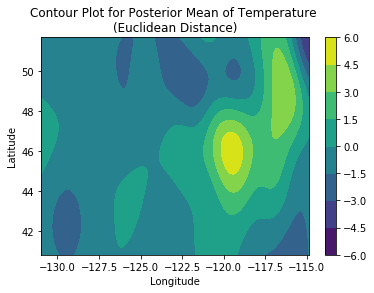

In [165]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

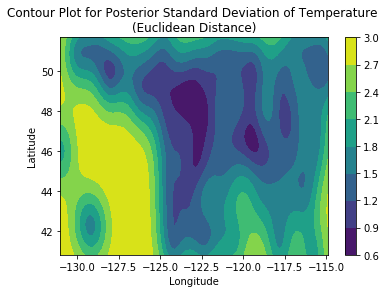

In [166]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                                               posterior_predictive_value=np.sqrt(post_pred_var))

#### (Tuned) Non-Isotropic Distance:

In [167]:
start_x = [b1, b2, tau_1_sqd]
nm_options = {'disp': True, 'xatol': 1e-8, 'fatol': 1e-8}
opt_pars = spo.minimize(fun=Nelder_Mead_objective_function, x0=start_x, method='Nelder-Mead', options=nm_options)
tuned_b1, tuned_b2, tuned_tau_1_sqd = opt_pars['x']
print(opt_pars['x'])

Optimization terminated successfully.
         Current function value: 350.166815
         Iterations: 107
         Function evaluations: 221
[2.43147357 1.3532967  3.08852156]


In [168]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=tuned_b1, b2=tuned_b2, tau_1_sqd=tuned_tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

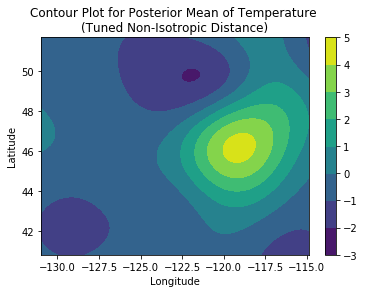

In [169]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

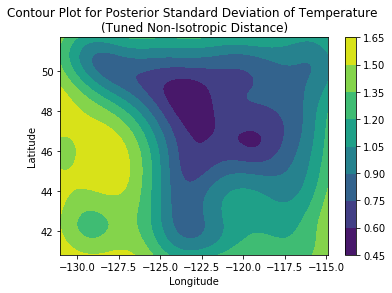

In [170]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                   posterior_predictive_value=np.sqrt(post_pred_var))

#### **Covariance Function: Matern(5/2)**

In [171]:
cov_function = 'm52'

#### Euclidean Distance:

In [172]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=b1, b2=b2, tau_1_sqd=tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

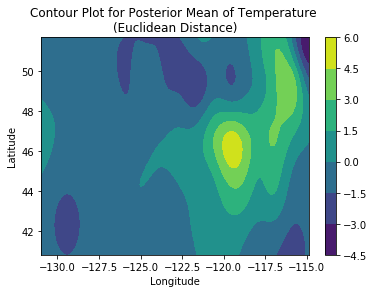

In [173]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

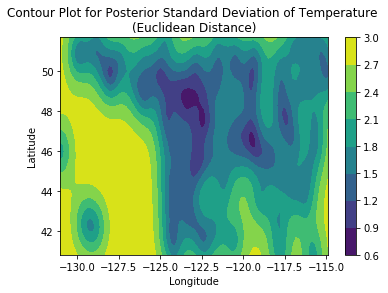

In [174]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                                               posterior_predictive_value=np.sqrt(post_pred_var))

#### (Tuned) Non-Isotropic Distance:

In [175]:
start_x = [b1, b2, tau_1_sqd]
nm_options = {'disp': True, 'xatol': 1e-8, 'fatol': 1e-8}
opt_pars = spo.minimize(fun=Nelder_Mead_objective_function, x0=start_x, method='Nelder-Mead', options=nm_options)
tuned_b1, tuned_b2, tuned_tau_1_sqd = opt_pars['x']
print(opt_pars['x'])

Optimization terminated successfully.
         Current function value: 349.988869
         Iterations: 112
         Function evaluations: 229
[2.92771467 0.52154904 3.13570922]


In [176]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=tuned_b1, b2=tuned_b2, tau_1_sqd=tuned_tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

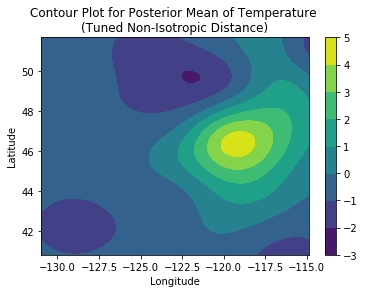

In [177]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

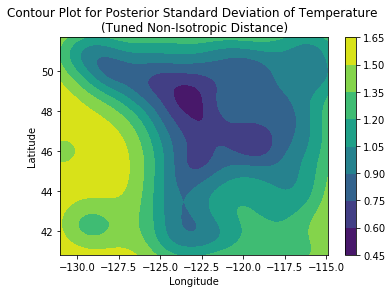

In [178]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                   posterior_predictive_value=np.sqrt(post_pred_var))

We observe that for temperature data, the contour plots of both Euclidean distances and non-isotropic distances look similar between two covariance functions; and after tuning the hyperparameters $b_1$, $b_2$ and $\tau_1^2$ using Nelder-Mead method, the contour plots appear to be much smoother.

### **Pressure**
#### **Covariance Function: Squared Exponential**

In [180]:
current_y = pressure
# compute variance of y as our empirical sigma2
empirical_sigma2 = np.var(current_y)
b1, b2, tau_1_sqd, tau_2_sqd = 1., 1., 9., 1e-6
cov_function = 'se'

#### Euclidean Distance:

In [181]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=b1, b2=b2, tau_1_sqd=tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

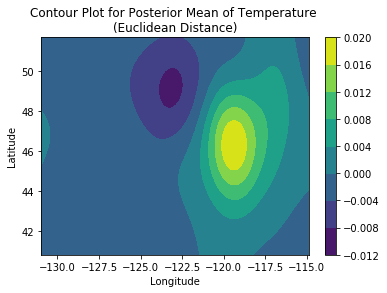

In [182]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

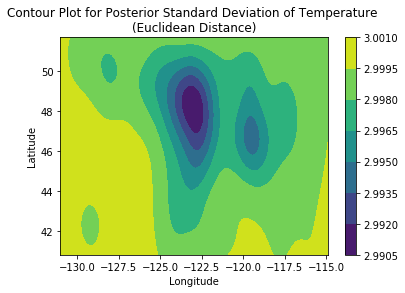

In [183]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                                               posterior_predictive_value=np.sqrt(post_pred_var))

#### (Tuned) Non-Isotropic Distance:

In [188]:
start_x = [b1, b2, tau_1_sqd]
nm_options = {'disp': True, 'xatol': 1e-8, 'fatol': 1e-8}
opt_pars = spo.minimize(fun=Nelder_Mead_objective_function, x0=start_x, method='Nelder-Mead', options=nm_options)
tuned_b1, tuned_b2, tuned_tau_1_sqd = opt_pars['x']
print(opt_pars['x'])

[    3.62364927 -3113.79306366 34309.69332087]


In [189]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=tuned_b1, b2=tuned_b2, tau_1_sqd=tuned_tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

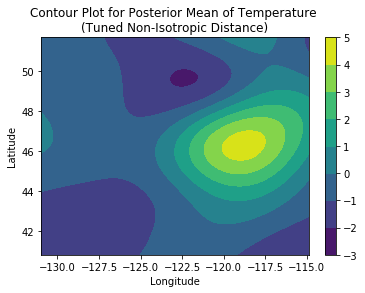

In [190]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

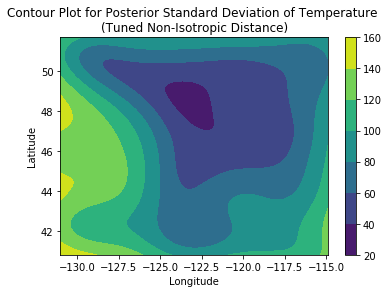

In [191]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                   posterior_predictive_value=np.sqrt(post_pred_var))

#### **Covariance Function: Matern(5/2)**

In [192]:
cov_function = 'm52'

#### Euclidean Distance:

In [193]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=b1, b2=b2, tau_1_sqd=tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

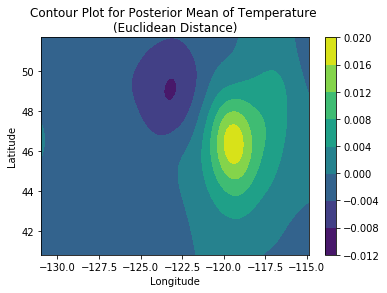

In [194]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

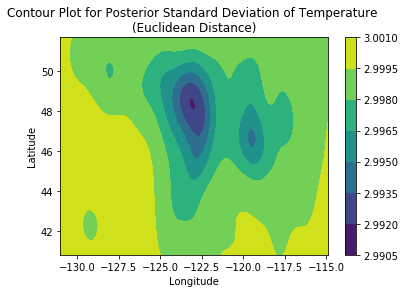

In [195]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Euclidean Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                                               posterior_predictive_value=np.sqrt(post_pred_var))

#### (Tuned) Non-Isotropic Distance:

In [196]:
start_x = [b1, b2, tau_1_sqd]
nm_options = {'disp': True, 'xatol': 1e-8, 'fatol': 1e-8}
opt_pars = spo.minimize(fun=Nelder_Mead_objective_function, x0=start_x, method='Nelder-Mead', options=nm_options)
tuned_b1, tuned_b2, tuned_tau_1_sqd = opt_pars['x']
print(opt_pars['x'])

Optimization terminated successfully.
         Current function value: 1023.956021
         Iterations: 256
         Function evaluations: 542
[    4.23870129 -3001.89795064 30785.15734491]


In [197]:
post_pred_mean, post_pred_var, lon_grid, lat_grid = compute_predictive_mean_and_variance(y=y, lon=lon, lat=lat, b1=tuned_b1, b2=tuned_b2, tau_1_sqd=tuned_tau_1_sqd, \
                                                                                         tau_2_sqd=tau_2_sqd, sigma2=empirical_sigma2, granularity=500, cov_func=cov_function)

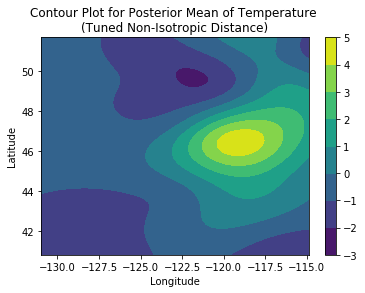

In [198]:
draw_contour_plot_for_weather_data(value="Mean", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, posterior_predictive_value=post_pred_mean)

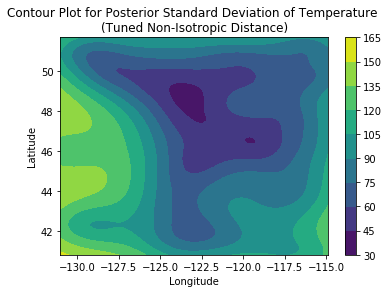

In [199]:
draw_contour_plot_for_weather_data(value="Standard Deviation", data="Temperature \n(Tuned Non-Isotropic Distance)", lon_grid=lon_grid, lat_grid=lat_grid, \
                                   posterior_predictive_value=np.sqrt(post_pred_var))

We observe that for pressure data, the contour plots of both Euclidean distances and non-isotropic distances look similar between two covariance functions; however, the contours are already looking smooth before tuning the hyperparameters $b_1$, $b_2$ and $\tau_1^2$ using Nelder-Mead method, the this method actually gives weird results -- $b_2$ and $\tau_1^2$ are having huge magnitudes for both covariance functions.